In [677]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import numpy as np
import foolbox

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [678]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=10)
if torch.cuda.is_available():
    vae.cuda()

In [1294]:
class VAE18(nn.Module):
    def __init__(self, z_dim=128):
        super(VAE18, self).__init__()

        # Encoder
        self.conv0 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2, bias= False)
        self.conv0_bn = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=3, bias= False)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias= False)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias= False)
        self.conv3_bn = nn.BatchNorm2d(256)
        # Latent space
        self.fc21 = nn.Linear(4096, z_dim)
        self.fc22 = nn.Linear(4096, z_dim)

        # Decoder
        self.fc3 = nn.Linear(z_dim, 4096)
        self.fc3_bn = nn.BatchNorm1d(4096)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias= False)
        self.deconv1_bn = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias= False)
        self.deconv2_bn = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=3, bias= False)
        self.deconv3_bn = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 1, kernel_size=5, stride=1, padding=2, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        out = self.relu(self.conv0_bn(self.conv0(x)))
        out = self.relu(self.conv1_bn(self.conv1(out)))
        out = self.relu(self.conv2_bn(self.conv2(out)))
        out = self.relu(self.conv3_bn(self.conv3(out)))
        h1 = out.view(out.size(0), -1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        #if self.training:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        #else:
        #    return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        out = h3.view(h3.size(0), 256, 4, 4)
        out = self.relu(self.deconv1_bn(self.deconv1(out)))
        out = self.relu(self.deconv2_bn(self.deconv2(out)))
        out = self.relu(self.deconv3_bn(self.deconv3(out)))
        out = self.sigmoid(self.deconv4(out))
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD, BCE, KLD

In [1295]:
vae = VAE18(z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [1296]:
vae

VAE18(
  (conv0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv0_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=4096, out_features=2, bias=True)
  (fc22): Linear(in_features=4096, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=4096, bias=True)
  (fc3_bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, trac

In [1301]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x.view(-1,784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD, BCE, KLD

In [1302]:
%matplotlib inline
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss, bc, kld = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #print(recon_batch.shape)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tKLD: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data), kld.item() / len(data)))
            #plt.imshow(data[0].cpu().squeeze().detach().numpy(), cmap='gray')
            #plt.imshow(recon_batch[0].view((-1, 28, 28)).cpu().squeeze().detach().numpy(), cmap='gray')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    plt.subplot(2,1,1)
    plt.imshow(data[0].cpu().squeeze().detach().numpy(), cmap='gray')
    plt.subplot(2,1,2)
    plt.imshow(recon_batch[0].view((-1, 28, 28)).cpu().squeeze().detach().numpy(), cmap='gray')

In [1303]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            l, b, k = loss_function(recon, data, mu, log_var)
            test_loss += l.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    plt.subplot(2,1,1)
    plt.imshow(data[0].cpu().squeeze().detach().numpy(), cmap='gray')
    plt.subplot(2,1,2)
    plt.imshow(recon[0].view((-1, 28, 28)).cpu().squeeze().detach().numpy(), cmap='gray')

Train Epoch: 1 [0/60000 (0%)]	Loss: 149.986240	KLD: 5.9108
Train Epoch: 1 [10000/60000 (17%)]	Loss: 151.623652	KLD: 6.1943
Train Epoch: 1 [20000/60000 (33%)]	Loss: 153.443096	KLD: 6.1764
Train Epoch: 1 [30000/60000 (50%)]	Loss: 158.116006	KLD: 6.3184
Train Epoch: 1 [40000/60000 (67%)]	Loss: 154.453125	KLD: 5.9289
Train Epoch: 1 [50000/60000 (83%)]	Loss: 146.264395	KLD: 6.1986
====> Epoch: 1 Average loss: 152.3789
====> Test set loss: 150.0579
Train Epoch: 2 [0/60000 (0%)]	Loss: 151.840166	KLD: 6.0265


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 2 [10000/60000 (17%)]	Loss: 143.391592	KLD: 6.0902
Train Epoch: 2 [20000/60000 (33%)]	Loss: 147.606396	KLD: 6.4060
Train Epoch: 2 [30000/60000 (50%)]	Loss: 140.446602	KLD: 6.2597
Train Epoch: 2 [40000/60000 (67%)]	Loss: 145.215830	KLD: 6.1127
Train Epoch: 2 [50000/60000 (83%)]	Loss: 157.187715	KLD: 6.3747
====> Epoch: 2 Average loss: 148.8873


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 147.3060
Train Epoch: 3 [0/60000 (0%)]	Loss: 147.781318	KLD: 6.2558


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 3 [10000/60000 (17%)]	Loss: 139.135225	KLD: 6.3039
Train Epoch: 3 [20000/60000 (33%)]	Loss: 154.579355	KLD: 5.9954
Train Epoch: 3 [30000/60000 (50%)]	Loss: 140.897207	KLD: 6.6363
Train Epoch: 3 [40000/60000 (67%)]	Loss: 145.003457	KLD: 6.4313
Train Epoch: 3 [50000/60000 (83%)]	Loss: 146.745557	KLD: 6.4924
====> Epoch: 3 Average loss: 146.8270


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 145.6896
Train Epoch: 4 [0/60000 (0%)]	Loss: 151.145371	KLD: 6.4900


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 4 [10000/60000 (17%)]	Loss: 143.895957	KLD: 6.8122
Train Epoch: 4 [20000/60000 (33%)]	Loss: 144.277432	KLD: 6.2594
Train Epoch: 4 [30000/60000 (50%)]	Loss: 141.142217	KLD: 6.2696
Train Epoch: 4 [40000/60000 (67%)]	Loss: 147.215469	KLD: 6.7400
Train Epoch: 4 [50000/60000 (83%)]	Loss: 146.424951	KLD: 6.2838
====> Epoch: 4 Average loss: 145.3519


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 144.7215
Train Epoch: 5 [0/60000 (0%)]	Loss: 146.347520	KLD: 6.2487


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 5 [10000/60000 (17%)]	Loss: 144.321074	KLD: 6.5226
Train Epoch: 5 [20000/60000 (33%)]	Loss: 146.209551	KLD: 6.7553
Train Epoch: 5 [30000/60000 (50%)]	Loss: 146.719902	KLD: 6.8587
Train Epoch: 5 [40000/60000 (67%)]	Loss: 147.183770	KLD: 6.5692
Train Epoch: 5 [50000/60000 (83%)]	Loss: 144.097813	KLD: 6.0236
====> Epoch: 5 Average loss: 144.2558


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 142.7414
Train Epoch: 6 [0/60000 (0%)]	Loss: 138.150107	KLD: 6.4783


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 6 [10000/60000 (17%)]	Loss: 141.979961	KLD: 6.2958
Train Epoch: 6 [20000/60000 (33%)]	Loss: 138.863945	KLD: 6.5985
Train Epoch: 6 [30000/60000 (50%)]	Loss: 148.853066	KLD: 6.5966
Train Epoch: 6 [40000/60000 (67%)]	Loss: 148.574600	KLD: 6.7758
Train Epoch: 6 [50000/60000 (83%)]	Loss: 145.409570	KLD: 6.4533
====> Epoch: 6 Average loss: 143.2016


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 142.8275
Train Epoch: 7 [0/60000 (0%)]	Loss: 146.231846	KLD: 6.5490


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 7 [10000/60000 (17%)]	Loss: 138.647061	KLD: 6.3639
Train Epoch: 7 [20000/60000 (33%)]	Loss: 142.475713	KLD: 6.7011
Train Epoch: 7 [30000/60000 (50%)]	Loss: 149.561396	KLD: 6.6848
Train Epoch: 7 [40000/60000 (67%)]	Loss: 141.298711	KLD: 6.4211
Train Epoch: 7 [50000/60000 (83%)]	Loss: 131.398662	KLD: 6.6027
====> Epoch: 7 Average loss: 142.1342


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 141.5777
Train Epoch: 8 [0/60000 (0%)]	Loss: 136.703301	KLD: 6.4609


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 8 [10000/60000 (17%)]	Loss: 144.708506	KLD: 6.5607
Train Epoch: 8 [20000/60000 (33%)]	Loss: 138.975830	KLD: 6.7325
Train Epoch: 8 [30000/60000 (50%)]	Loss: 132.541533	KLD: 6.7586
Train Epoch: 8 [40000/60000 (67%)]	Loss: 141.876416	KLD: 6.6630
Train Epoch: 8 [50000/60000 (83%)]	Loss: 131.399814	KLD: 6.4459
====> Epoch: 8 Average loss: 141.5099


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 141.5375
Train Epoch: 9 [0/60000 (0%)]	Loss: 136.688564	KLD: 6.4947


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 9 [10000/60000 (17%)]	Loss: 147.076016	KLD: 6.8555
Train Epoch: 9 [20000/60000 (33%)]	Loss: 132.197051	KLD: 6.5526
Train Epoch: 9 [30000/60000 (50%)]	Loss: 143.042305	KLD: 6.9515
Train Epoch: 9 [40000/60000 (67%)]	Loss: 146.604951	KLD: 7.0139
Train Epoch: 9 [50000/60000 (83%)]	Loss: 147.124766	KLD: 6.9190
====> Epoch: 9 Average loss: 141.0464


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 141.3031
Train Epoch: 10 [0/60000 (0%)]	Loss: 151.853359	KLD: 6.7817


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 10 [10000/60000 (17%)]	Loss: 137.057881	KLD: 6.7530
Train Epoch: 10 [20000/60000 (33%)]	Loss: 142.986963	KLD: 6.7012
Train Epoch: 10 [30000/60000 (50%)]	Loss: 136.602354	KLD: 6.8227
Train Epoch: 10 [40000/60000 (67%)]	Loss: 145.080127	KLD: 6.7395
Train Epoch: 10 [50000/60000 (83%)]	Loss: 142.307109	KLD: 6.9705
====> Epoch: 10 Average loss: 140.3431


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 140.4920
Train Epoch: 11 [0/60000 (0%)]	Loss: 149.142793	KLD: 6.6488


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 11 [10000/60000 (17%)]	Loss: 139.799561	KLD: 6.8707
Train Epoch: 11 [20000/60000 (33%)]	Loss: 146.368730	KLD: 6.9152
Train Epoch: 11 [30000/60000 (50%)]	Loss: 142.633838	KLD: 7.0203
Train Epoch: 11 [40000/60000 (67%)]	Loss: 127.748467	KLD: 6.6048
Train Epoch: 11 [50000/60000 (83%)]	Loss: 140.850967	KLD: 6.5306
====> Epoch: 11 Average loss: 139.9922


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 140.3697
Train Epoch: 12 [0/60000 (0%)]	Loss: 141.810664	KLD: 6.9178


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 12 [10000/60000 (17%)]	Loss: 124.013848	KLD: 6.3344
Train Epoch: 12 [20000/60000 (33%)]	Loss: 128.919053	KLD: 6.5609
Train Epoch: 12 [30000/60000 (50%)]	Loss: 145.786045	KLD: 6.9423
Train Epoch: 12 [40000/60000 (67%)]	Loss: 142.463477	KLD: 6.7017
Train Epoch: 12 [50000/60000 (83%)]	Loss: 138.912910	KLD: 6.5073
====> Epoch: 12 Average loss: 139.4048


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 140.5495
Train Epoch: 13 [0/60000 (0%)]	Loss: 144.152266	KLD: 6.9061


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 13 [10000/60000 (17%)]	Loss: 141.804629	KLD: 7.0324
Train Epoch: 13 [20000/60000 (33%)]	Loss: 131.898779	KLD: 6.8270
Train Epoch: 13 [30000/60000 (50%)]	Loss: 138.131348	KLD: 6.8490
Train Epoch: 13 [40000/60000 (67%)]	Loss: 144.556191	KLD: 6.9869
Train Epoch: 13 [50000/60000 (83%)]	Loss: 136.073740	KLD: 6.8251
====> Epoch: 13 Average loss: 139.0195


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 139.8711
Train Epoch: 14 [0/60000 (0%)]	Loss: 134.943779	KLD: 6.8681


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 14 [10000/60000 (17%)]	Loss: 134.504570	KLD: 6.8178
Train Epoch: 14 [20000/60000 (33%)]	Loss: 131.294941	KLD: 6.8456
Train Epoch: 14 [30000/60000 (50%)]	Loss: 147.850996	KLD: 6.9467
Train Epoch: 14 [40000/60000 (67%)]	Loss: 135.321035	KLD: 6.5774
Train Epoch: 14 [50000/60000 (83%)]	Loss: 142.044209	KLD: 6.4486
====> Epoch: 14 Average loss: 138.6155


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 139.7626
Train Epoch: 15 [0/60000 (0%)]	Loss: 145.789551	KLD: 7.1197


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 15 [10000/60000 (17%)]	Loss: 137.644219	KLD: 7.1049
Train Epoch: 15 [20000/60000 (33%)]	Loss: 150.033701	KLD: 6.6469
Train Epoch: 15 [30000/60000 (50%)]	Loss: 137.193164	KLD: 6.5626
Train Epoch: 15 [40000/60000 (67%)]	Loss: 136.176172	KLD: 6.3431
Train Epoch: 15 [50000/60000 (83%)]	Loss: 136.470352	KLD: 6.2771
====> Epoch: 15 Average loss: 138.4072


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 139.7210
Train Epoch: 16 [0/60000 (0%)]	Loss: 142.669707	KLD: 6.5717


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 16 [10000/60000 (17%)]	Loss: 141.852988	KLD: 6.6754
Train Epoch: 16 [20000/60000 (33%)]	Loss: 140.062070	KLD: 6.9561
Train Epoch: 16 [30000/60000 (50%)]	Loss: 136.354658	KLD: 6.9826
Train Epoch: 16 [40000/60000 (67%)]	Loss: 135.823320	KLD: 6.5745
Train Epoch: 16 [50000/60000 (83%)]	Loss: 142.912061	KLD: 7.0087
====> Epoch: 16 Average loss: 137.9271


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 139.2681
Train Epoch: 17 [0/60000 (0%)]	Loss: 135.485283	KLD: 6.7918


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 17 [10000/60000 (17%)]	Loss: 141.980674	KLD: 7.0495
Train Epoch: 17 [20000/60000 (33%)]	Loss: 137.071074	KLD: 7.1406
Train Epoch: 17 [30000/60000 (50%)]	Loss: 135.632305	KLD: 6.6500
Train Epoch: 17 [40000/60000 (67%)]	Loss: 132.992734	KLD: 6.5239
Train Epoch: 17 [50000/60000 (83%)]	Loss: 141.223467	KLD: 6.7953
====> Epoch: 17 Average loss: 137.6835


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 139.0335
Train Epoch: 18 [0/60000 (0%)]	Loss: 141.395186	KLD: 7.0559


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 18 [10000/60000 (17%)]	Loss: 130.554707	KLD: 6.5372
Train Epoch: 18 [20000/60000 (33%)]	Loss: 127.274717	KLD: 6.6821
Train Epoch: 18 [30000/60000 (50%)]	Loss: 146.424014	KLD: 7.1858
Train Epoch: 18 [40000/60000 (67%)]	Loss: 137.630137	KLD: 6.7590
Train Epoch: 18 [50000/60000 (83%)]	Loss: 133.813086	KLD: 6.5227
====> Epoch: 18 Average loss: 137.3800


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 139.7761
Train Epoch: 19 [0/60000 (0%)]	Loss: 131.815039	KLD: 6.7505


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 19 [10000/60000 (17%)]	Loss: 130.872588	KLD: 6.8632
Train Epoch: 19 [20000/60000 (33%)]	Loss: 127.396309	KLD: 6.5966
Train Epoch: 19 [30000/60000 (50%)]	Loss: 141.902764	KLD: 6.9774
Train Epoch: 19 [40000/60000 (67%)]	Loss: 137.519658	KLD: 7.0415
Train Epoch: 19 [50000/60000 (83%)]	Loss: 134.972471	KLD: 6.6976
====> Epoch: 19 Average loss: 137.1085


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.5857
Train Epoch: 20 [0/60000 (0%)]	Loss: 132.367451	KLD: 6.8756


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 20 [10000/60000 (17%)]	Loss: 138.707100	KLD: 6.8363
Train Epoch: 20 [20000/60000 (33%)]	Loss: 137.035322	KLD: 7.3839
Train Epoch: 20 [30000/60000 (50%)]	Loss: 135.912627	KLD: 6.9484
Train Epoch: 20 [40000/60000 (67%)]	Loss: 135.300732	KLD: 6.7710
Train Epoch: 20 [50000/60000 (83%)]	Loss: 130.637969	KLD: 6.4063
====> Epoch: 20 Average loss: 136.8780


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.6947
Train Epoch: 21 [0/60000 (0%)]	Loss: 131.356895	KLD: 6.8918


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 21 [10000/60000 (17%)]	Loss: 134.137725	KLD: 6.6778
Train Epoch: 21 [20000/60000 (33%)]	Loss: 131.508379	KLD: 7.0429
Train Epoch: 21 [30000/60000 (50%)]	Loss: 133.092061	KLD: 7.0743
Train Epoch: 21 [40000/60000 (67%)]	Loss: 133.760820	KLD: 6.7371
Train Epoch: 21 [50000/60000 (83%)]	Loss: 136.757129	KLD: 7.4603
====> Epoch: 21 Average loss: 136.5757


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.3218
Train Epoch: 22 [0/60000 (0%)]	Loss: 138.778115	KLD: 6.8960


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 22 [10000/60000 (17%)]	Loss: 130.774531	KLD: 6.8153
Train Epoch: 22 [20000/60000 (33%)]	Loss: 133.126465	KLD: 6.7625
Train Epoch: 22 [30000/60000 (50%)]	Loss: 131.603418	KLD: 6.8443
Train Epoch: 22 [40000/60000 (67%)]	Loss: 138.081152	KLD: 6.8536
Train Epoch: 22 [50000/60000 (83%)]	Loss: 133.398506	KLD: 6.7906
====> Epoch: 22 Average loss: 136.3743


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.3432
Train Epoch: 23 [0/60000 (0%)]	Loss: 127.176377	KLD: 6.7684


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 23 [10000/60000 (17%)]	Loss: 133.910186	KLD: 7.0780
Train Epoch: 23 [20000/60000 (33%)]	Loss: 137.964424	KLD: 6.6719
Train Epoch: 23 [30000/60000 (50%)]	Loss: 142.529854	KLD: 6.7226
Train Epoch: 23 [40000/60000 (67%)]	Loss: 141.069736	KLD: 6.8469
Train Epoch: 23 [50000/60000 (83%)]	Loss: 138.426348	KLD: 7.0013
====> Epoch: 23 Average loss: 136.0920


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.5050
Train Epoch: 24 [0/60000 (0%)]	Loss: 134.495762	KLD: 6.9815


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 24 [10000/60000 (17%)]	Loss: 134.060088	KLD: 6.6396
Train Epoch: 24 [20000/60000 (33%)]	Loss: 129.309316	KLD: 7.1325
Train Epoch: 24 [30000/60000 (50%)]	Loss: 134.198789	KLD: 6.8287
Train Epoch: 24 [40000/60000 (67%)]	Loss: 130.459609	KLD: 6.6612
Train Epoch: 24 [50000/60000 (83%)]	Loss: 140.320215	KLD: 7.0198
====> Epoch: 24 Average loss: 135.9325


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.3515
Train Epoch: 25 [0/60000 (0%)]	Loss: 138.563701	KLD: 6.9046


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 25 [10000/60000 (17%)]	Loss: 134.443555	KLD: 7.0764
Train Epoch: 25 [20000/60000 (33%)]	Loss: 131.789268	KLD: 6.8590
Train Epoch: 25 [30000/60000 (50%)]	Loss: 140.438857	KLD: 7.4794
Train Epoch: 25 [40000/60000 (67%)]	Loss: 138.671846	KLD: 6.7212
Train Epoch: 25 [50000/60000 (83%)]	Loss: 132.752979	KLD: 6.8356
====> Epoch: 25 Average loss: 135.8389


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.3761
Train Epoch: 26 [0/60000 (0%)]	Loss: 128.777773	KLD: 6.7966


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 26 [10000/60000 (17%)]	Loss: 135.852734	KLD: 7.1561
Train Epoch: 26 [20000/60000 (33%)]	Loss: 134.494531	KLD: 7.0780
Train Epoch: 26 [30000/60000 (50%)]	Loss: 141.570254	KLD: 7.2535
Train Epoch: 26 [40000/60000 (67%)]	Loss: 133.791455	KLD: 7.0600
Train Epoch: 26 [50000/60000 (83%)]	Loss: 148.762021	KLD: 6.9031
====> Epoch: 26 Average loss: 135.5308


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.8664
Train Epoch: 27 [0/60000 (0%)]	Loss: 135.554658	KLD: 7.2127


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 27 [10000/60000 (17%)]	Loss: 133.723213	KLD: 7.1513
Train Epoch: 27 [20000/60000 (33%)]	Loss: 140.720957	KLD: 7.1915
Train Epoch: 27 [30000/60000 (50%)]	Loss: 135.126709	KLD: 6.9657
Train Epoch: 27 [40000/60000 (67%)]	Loss: 129.939102	KLD: 7.0110
Train Epoch: 27 [50000/60000 (83%)]	Loss: 133.194668	KLD: 7.3425
====> Epoch: 27 Average loss: 135.3617


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.0324
Train Epoch: 28 [0/60000 (0%)]	Loss: 145.035264	KLD: 6.9904


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 28 [10000/60000 (17%)]	Loss: 133.213379	KLD: 7.2598
Train Epoch: 28 [20000/60000 (33%)]	Loss: 129.472490	KLD: 7.1173
Train Epoch: 28 [30000/60000 (50%)]	Loss: 137.477217	KLD: 7.0632
Train Epoch: 28 [40000/60000 (67%)]	Loss: 140.241914	KLD: 7.1644
Train Epoch: 28 [50000/60000 (83%)]	Loss: 139.807334	KLD: 7.2540
====> Epoch: 28 Average loss: 135.1642


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.3878
Train Epoch: 29 [0/60000 (0%)]	Loss: 126.563262	KLD: 7.2919


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 29 [10000/60000 (17%)]	Loss: 130.327266	KLD: 7.0235
Train Epoch: 29 [20000/60000 (33%)]	Loss: 136.794277	KLD: 6.8410
Train Epoch: 29 [30000/60000 (50%)]	Loss: 126.380313	KLD: 6.8688
Train Epoch: 29 [40000/60000 (67%)]	Loss: 131.741367	KLD: 7.0699
Train Epoch: 29 [50000/60000 (83%)]	Loss: 130.104189	KLD: 6.7773
====> Epoch: 29 Average loss: 135.0669


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.5291
Train Epoch: 30 [0/60000 (0%)]	Loss: 132.386650	KLD: 6.9806


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 30 [10000/60000 (17%)]	Loss: 131.718643	KLD: 7.1613
Train Epoch: 30 [20000/60000 (33%)]	Loss: 135.314590	KLD: 7.0607
Train Epoch: 30 [30000/60000 (50%)]	Loss: 134.879814	KLD: 7.1043
Train Epoch: 30 [40000/60000 (67%)]	Loss: 136.643359	KLD: 7.3173
Train Epoch: 30 [50000/60000 (83%)]	Loss: 135.260234	KLD: 7.0475
====> Epoch: 30 Average loss: 134.9366


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.7190
Train Epoch: 31 [0/60000 (0%)]	Loss: 143.269219	KLD: 7.0337


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 31 [10000/60000 (17%)]	Loss: 138.076191	KLD: 7.1421
Train Epoch: 31 [20000/60000 (33%)]	Loss: 130.287510	KLD: 7.0105
Train Epoch: 31 [30000/60000 (50%)]	Loss: 134.638799	KLD: 7.2990
Train Epoch: 31 [40000/60000 (67%)]	Loss: 138.251504	KLD: 7.2365
Train Epoch: 31 [50000/60000 (83%)]	Loss: 136.845293	KLD: 7.1439
====> Epoch: 31 Average loss: 134.6587


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.8829
Train Epoch: 32 [0/60000 (0%)]	Loss: 134.004951	KLD: 7.0045


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 32 [10000/60000 (17%)]	Loss: 139.221299	KLD: 6.9981
Train Epoch: 32 [20000/60000 (33%)]	Loss: 136.103574	KLD: 7.3146
Train Epoch: 32 [30000/60000 (50%)]	Loss: 136.889932	KLD: 7.3197
Train Epoch: 32 [40000/60000 (67%)]	Loss: 139.468467	KLD: 7.3158
Train Epoch: 32 [50000/60000 (83%)]	Loss: 137.212939	KLD: 7.1522
====> Epoch: 32 Average loss: 134.5394


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.0537
Train Epoch: 33 [0/60000 (0%)]	Loss: 130.366523	KLD: 7.4238


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 33 [10000/60000 (17%)]	Loss: 132.747275	KLD: 7.1484
Train Epoch: 33 [20000/60000 (33%)]	Loss: 130.775801	KLD: 7.1666
Train Epoch: 33 [30000/60000 (50%)]	Loss: 132.425459	KLD: 6.8962
Train Epoch: 33 [40000/60000 (67%)]	Loss: 130.833203	KLD: 7.3628
Train Epoch: 33 [50000/60000 (83%)]	Loss: 134.300684	KLD: 7.2300
====> Epoch: 33 Average loss: 134.4504


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.7860
Train Epoch: 34 [0/60000 (0%)]	Loss: 136.484219	KLD: 7.2433


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 34 [10000/60000 (17%)]	Loss: 136.791172	KLD: 7.2861
Train Epoch: 34 [20000/60000 (33%)]	Loss: 139.701494	KLD: 7.1848
Train Epoch: 34 [30000/60000 (50%)]	Loss: 126.799863	KLD: 6.9780
Train Epoch: 34 [40000/60000 (67%)]	Loss: 138.526416	KLD: 7.0502
Train Epoch: 34 [50000/60000 (83%)]	Loss: 128.889258	KLD: 7.2698
====> Epoch: 34 Average loss: 134.1844


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.9979
Train Epoch: 35 [0/60000 (0%)]	Loss: 134.218896	KLD: 6.9428


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 35 [10000/60000 (17%)]	Loss: 134.591309	KLD: 7.2824
Train Epoch: 35 [20000/60000 (33%)]	Loss: 132.759297	KLD: 7.3835
Train Epoch: 35 [30000/60000 (50%)]	Loss: 131.621094	KLD: 7.1036
Train Epoch: 35 [40000/60000 (67%)]	Loss: 140.698164	KLD: 6.9701
Train Epoch: 35 [50000/60000 (83%)]	Loss: 140.139980	KLD: 7.0206
====> Epoch: 35 Average loss: 133.9868


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.9472
Train Epoch: 36 [0/60000 (0%)]	Loss: 129.978447	KLD: 7.1023


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 36 [10000/60000 (17%)]	Loss: 131.293770	KLD: 7.2515
Train Epoch: 36 [20000/60000 (33%)]	Loss: 140.347363	KLD: 7.1609
Train Epoch: 36 [30000/60000 (50%)]	Loss: 130.976562	KLD: 7.0596
Train Epoch: 36 [40000/60000 (67%)]	Loss: 130.448047	KLD: 7.3157
Train Epoch: 36 [50000/60000 (83%)]	Loss: 129.020527	KLD: 7.3322
====> Epoch: 36 Average loss: 134.0579


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.4814
Train Epoch: 37 [0/60000 (0%)]	Loss: 135.663936	KLD: 7.3282


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 37 [10000/60000 (17%)]	Loss: 131.374990	KLD: 7.2979
Train Epoch: 37 [20000/60000 (33%)]	Loss: 131.916035	KLD: 7.5767
Train Epoch: 37 [30000/60000 (50%)]	Loss: 137.651934	KLD: 7.3005
Train Epoch: 37 [40000/60000 (67%)]	Loss: 127.801113	KLD: 7.2559
Train Epoch: 37 [50000/60000 (83%)]	Loss: 139.658555	KLD: 7.2102
====> Epoch: 37 Average loss: 133.7518


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.5823
Train Epoch: 38 [0/60000 (0%)]	Loss: 131.971816	KLD: 7.3424


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 38 [10000/60000 (17%)]	Loss: 141.739707	KLD: 7.0835
Train Epoch: 38 [20000/60000 (33%)]	Loss: 127.066064	KLD: 7.1298
Train Epoch: 38 [30000/60000 (50%)]	Loss: 137.554648	KLD: 7.0539
Train Epoch: 38 [40000/60000 (67%)]	Loss: 134.213174	KLD: 7.4797
Train Epoch: 38 [50000/60000 (83%)]	Loss: 137.370166	KLD: 7.0771
====> Epoch: 38 Average loss: 133.7626


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.6036
Train Epoch: 39 [0/60000 (0%)]	Loss: 133.154385	KLD: 7.2022


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 39 [10000/60000 (17%)]	Loss: 142.855205	KLD: 7.4036
Train Epoch: 39 [20000/60000 (33%)]	Loss: 129.441602	KLD: 6.9828
Train Epoch: 39 [30000/60000 (50%)]	Loss: 135.671279	KLD: 7.0655
Train Epoch: 39 [40000/60000 (67%)]	Loss: 133.624990	KLD: 7.3232
Train Epoch: 39 [50000/60000 (83%)]	Loss: 130.926064	KLD: 7.2390
====> Epoch: 39 Average loss: 133.5739


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 138.0182
Train Epoch: 40 [0/60000 (0%)]	Loss: 134.002412	KLD: 7.3319


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 40 [10000/60000 (17%)]	Loss: 134.057051	KLD: 7.2486
Train Epoch: 40 [20000/60000 (33%)]	Loss: 133.025381	KLD: 7.2731
Train Epoch: 40 [30000/60000 (50%)]	Loss: 133.515234	KLD: 7.1470
Train Epoch: 40 [40000/60000 (67%)]	Loss: 139.197129	KLD: 7.3919
Train Epoch: 40 [50000/60000 (83%)]	Loss: 137.713711	KLD: 7.1925
====> Epoch: 40 Average loss: 133.4830


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.5467
Train Epoch: 41 [0/60000 (0%)]	Loss: 134.527861	KLD: 7.2628


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 41 [10000/60000 (17%)]	Loss: 132.463877	KLD: 7.2619
Train Epoch: 41 [20000/60000 (33%)]	Loss: 137.912246	KLD: 7.2300
Train Epoch: 41 [30000/60000 (50%)]	Loss: 133.269688	KLD: 7.2438
Train Epoch: 41 [40000/60000 (67%)]	Loss: 136.039170	KLD: 7.1685
Train Epoch: 41 [50000/60000 (83%)]	Loss: 133.971729	KLD: 7.1782
====> Epoch: 41 Average loss: 133.3010


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.5770
Train Epoch: 42 [0/60000 (0%)]	Loss: 129.034131	KLD: 7.1687


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 42 [10000/60000 (17%)]	Loss: 130.013320	KLD: 7.1889
Train Epoch: 42 [20000/60000 (33%)]	Loss: 132.085498	KLD: 7.0938
Train Epoch: 42 [30000/60000 (50%)]	Loss: 135.791143	KLD: 7.1998
Train Epoch: 42 [40000/60000 (67%)]	Loss: 132.254941	KLD: 7.1626
Train Epoch: 42 [50000/60000 (83%)]	Loss: 128.323545	KLD: 7.1656
====> Epoch: 42 Average loss: 133.1753


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.8534
Train Epoch: 43 [0/60000 (0%)]	Loss: 131.582305	KLD: 7.3617


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 43 [10000/60000 (17%)]	Loss: 125.629434	KLD: 7.1119
Train Epoch: 43 [20000/60000 (33%)]	Loss: 140.534980	KLD: 7.4330
Train Epoch: 43 [30000/60000 (50%)]	Loss: 133.554053	KLD: 7.2495
Train Epoch: 43 [40000/60000 (67%)]	Loss: 132.463193	KLD: 7.4049
Train Epoch: 43 [50000/60000 (83%)]	Loss: 137.094766	KLD: 7.3311
====> Epoch: 43 Average loss: 133.0448


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.4669
Train Epoch: 44 [0/60000 (0%)]	Loss: 134.618877	KLD: 7.0563


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 44 [10000/60000 (17%)]	Loss: 140.000254	KLD: 7.2082
Train Epoch: 44 [20000/60000 (33%)]	Loss: 134.881357	KLD: 7.1461
Train Epoch: 44 [30000/60000 (50%)]	Loss: 129.254434	KLD: 7.3402
Train Epoch: 44 [40000/60000 (67%)]	Loss: 128.590547	KLD: 7.1243
Train Epoch: 44 [50000/60000 (83%)]	Loss: 133.040312	KLD: 7.3503
====> Epoch: 44 Average loss: 132.9446


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.3669
Train Epoch: 45 [0/60000 (0%)]	Loss: 139.603457	KLD: 7.3489


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 45 [10000/60000 (17%)]	Loss: 138.309395	KLD: 7.6259
Train Epoch: 45 [20000/60000 (33%)]	Loss: 134.527988	KLD: 7.3527
Train Epoch: 45 [30000/60000 (50%)]	Loss: 134.615713	KLD: 7.3888
Train Epoch: 45 [40000/60000 (67%)]	Loss: 130.605410	KLD: 7.1910
Train Epoch: 45 [50000/60000 (83%)]	Loss: 126.672041	KLD: 7.1449
====> Epoch: 45 Average loss: 132.8190


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.7491
Train Epoch: 46 [0/60000 (0%)]	Loss: 129.872773	KLD: 6.9473


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 46 [10000/60000 (17%)]	Loss: 133.279766	KLD: 7.5452
Train Epoch: 46 [20000/60000 (33%)]	Loss: 123.487900	KLD: 7.2551
Train Epoch: 46 [30000/60000 (50%)]	Loss: 133.353945	KLD: 7.2041
Train Epoch: 46 [40000/60000 (67%)]	Loss: 135.256035	KLD: 7.2045
Train Epoch: 46 [50000/60000 (83%)]	Loss: 133.622998	KLD: 7.3547
====> Epoch: 46 Average loss: 132.8295


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.5502
Train Epoch: 47 [0/60000 (0%)]	Loss: 127.349150	KLD: 7.2699


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 47 [10000/60000 (17%)]	Loss: 130.636133	KLD: 7.3645
Train Epoch: 47 [20000/60000 (33%)]	Loss: 141.439277	KLD: 7.2560
Train Epoch: 47 [30000/60000 (50%)]	Loss: 130.992295	KLD: 7.1264
Train Epoch: 47 [40000/60000 (67%)]	Loss: 136.136348	KLD: 7.4091
Train Epoch: 47 [50000/60000 (83%)]	Loss: 126.548037	KLD: 7.5431
====> Epoch: 47 Average loss: 132.6554


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.9964
Train Epoch: 48 [0/60000 (0%)]	Loss: 135.851514	KLD: 7.4287


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 48 [10000/60000 (17%)]	Loss: 136.073535	KLD: 7.1062
Train Epoch: 48 [20000/60000 (33%)]	Loss: 130.815996	KLD: 7.3255
Train Epoch: 48 [30000/60000 (50%)]	Loss: 129.874512	KLD: 7.2881
Train Epoch: 48 [40000/60000 (67%)]	Loss: 129.983584	KLD: 7.3187
Train Epoch: 48 [50000/60000 (83%)]	Loss: 137.692422	KLD: 7.2204
====> Epoch: 48 Average loss: 132.4786


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.7105
Train Epoch: 49 [0/60000 (0%)]	Loss: 123.027012	KLD: 7.1032


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 49 [10000/60000 (17%)]	Loss: 124.827754	KLD: 7.2207
Train Epoch: 49 [20000/60000 (33%)]	Loss: 129.323623	KLD: 7.4234
Train Epoch: 49 [30000/60000 (50%)]	Loss: 128.901299	KLD: 7.0691
Train Epoch: 49 [40000/60000 (67%)]	Loss: 130.699297	KLD: 7.2901
Train Epoch: 49 [50000/60000 (83%)]	Loss: 135.623047	KLD: 7.0504
====> Epoch: 49 Average loss: 132.3506


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.5587
Train Epoch: 50 [0/60000 (0%)]	Loss: 133.683682	KLD: 7.0146


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Train Epoch: 50 [10000/60000 (17%)]	Loss: 134.548027	KLD: 7.0827
Train Epoch: 50 [20000/60000 (33%)]	Loss: 134.110713	KLD: 7.4007
Train Epoch: 50 [30000/60000 (50%)]	Loss: 126.058145	KLD: 7.3335
Train Epoch: 50 [40000/60000 (67%)]	Loss: 135.638232	KLD: 7.5323
Train Epoch: 50 [50000/60000 (83%)]	Loss: 139.910371	KLD: 7.2666
====> Epoch: 50 Average loss: 132.3878


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


====> Test set loss: 137.8194


/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


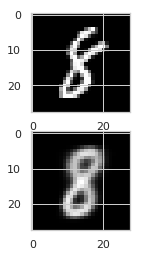

In [1304]:
# Check for checkpoint.
if not os.path.isdir('mnist_clf/'):
    os.makedirs('mnist_clf/')
files = os.listdir('mnist_clf/')
if 'vae_ckpt_conv_z2.pt' not in files:
    for epoch in range(1, 51):
        train(epoch)
        test()
        # Save the model
        #os.makedirs('mnist_clf/', exist_ok=True)
        torch.save(vae.state_dict(), 'mnist_clf/vae_ckpt_conv_z2.pt')
else:
    # Load the model
    vae.load_state_dict(torch.load('mnist_clf/vae_ckpt_conv_z2.pt'))

In [1307]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decode(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './mnist_samples/sample_' + '.png')
    #imgs = make_grid(sample)

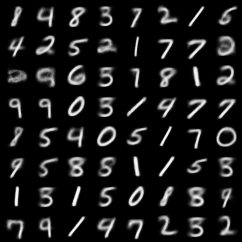

In [1308]:
from IPython.display import display, Image
display(Image(filename='mnist_samples/sample_.png'))

## Classifier

In [795]:
## Classifier

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [796]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args("")
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
c_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
c_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

if 'clf_ckpt.pt' not in os.listdir('mnist_clf'):
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, c_train_loader, optimizer, epoch)
        test(args, model, device, c_test_loader)
    #if (args.save_model):
    torch.save(model.state_dict(),"mnist_clf/clf_ckpt.pt")
else:
    model.load_state_dict(torch.load("mnist_clf/clf_ckpt.pt"))

In [797]:
model

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# Test

In [1309]:
itr = iter(c_test_loader)
#for i in range(2):
test1, lab1 = itr.next()

In [1310]:
i = test1[1].permute(1,2,0).data.squeeze().numpy()

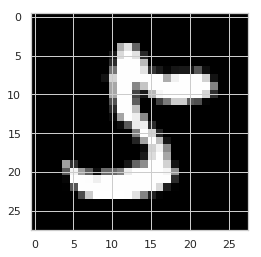

In [1311]:
plt.imshow(i, cmap='gray')

In [1312]:
test1.max()

tensor(2.8215)

In [1313]:
mean, std = 0.1307, 0.3081

In [1314]:
test1.shape

torch.Size([1000, 1, 28, 28])

In [1315]:
test1 = test1 * std + mean

In [1316]:
mu, logvar = vae.encode(test1[1].unsqueeze(0).cuda())

In [1317]:
logvar.exp().mean()

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)

In [1318]:
z = vae.reparameterize(mu, logvar)
rec_test1 = vae.decode(z)

In [1319]:
rec = rec_test1.view((1,28,28))

In [1320]:
i = rec.data.cpu().squeeze().numpy()

In [1321]:
model = model.eval()

In [1322]:
fmodel = foolbox.models.PyTorchModel(model, bounds=(-1, 1), num_classes=10, preprocessing=(mean, std))

In [1323]:
bleh = np.expand_dims(i, 0)
np.argmax(fmodel.predictions(bleh))

5

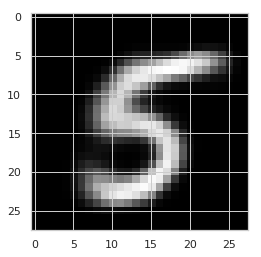

In [1324]:
plt.imshow(i, cmap='gray')

### Reconstruct the reconstructed

In [871]:
mu_1, logvar_1 = vae.encode(rec_test1)

In [872]:
z_1 = vae.reparameterize(mu_1, logvar_1)
rec_test2 = vae.decode(z_1)

In [873]:
rec_2 = rec_test2.view((1,28,28))

In [874]:
i_2 = rec_2.data.cpu().squeeze().numpy()

In [875]:
fmodel = foolbox.models.PyTorchModel(model, bounds=(-1, 1), num_classes=10, preprocessing=(mean, std))

In [876]:
bleh_2 = np.expand_dims(i_2, 0)
np.argmax(fmodel.predictions(bleh_2))

7

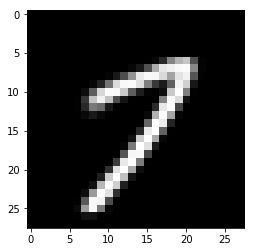

In [877]:
plt.imshow(i_2, cmap='gray')

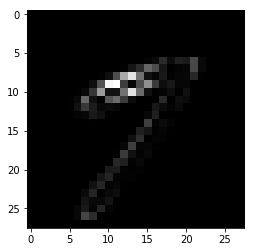

In [878]:
plt.imshow(abs(i-i_2), cmap='gray')

In [879]:
from scipy.stats import multivariate_normal
import numpy as np

In [1325]:
def find_prob(mu):
    # Here we find the probability of a particular latent variable
    # coming from a standard Normal N(0,I). We just use the mu value
    # we get. This is because the latent distribution is supposed
    # to be N(mu, var), and expectation of this is simply mu.

    probs = multivariate_normal.pdf(mu.data.cpu().numpy().transpose())

    mean_probs_dims = np.sum(np.log(probs))
    return probs, mean_probs_dims

In [1326]:
find_prob(mu)

(array([0.38149429, 0.39364362]), -1.8959686799908027)

In [882]:
find_prob(mu_1)

(array([0.39842759, 0.39893874, 0.39865207, 0.39842451, 0.39682298,
        0.39893536, 0.39889043, 0.39886821, 0.07298973, 0.39890904,
        0.39748322, 0.39857242, 0.38678502, 0.38496393, 0.39760035,
        0.39893496, 0.39894148, 0.39893447, 0.39893114, 0.39891719,
        0.39893713, 0.39893473, 0.39874596, 0.39876471, 0.39882741,
        0.39892031, 0.39882303, 0.39891448, 0.3987257 , 0.39893653,
        0.3988633 , 0.39262305, 0.09125584, 0.24216521, 0.39844882,
        0.39874673, 0.39880843, 0.39875307, 0.3988628 , 0.39894212,
        0.20056151, 0.14093083, 0.39848744, 0.39886477, 0.39862643,
        0.39889141, 0.39735628, 0.39842957, 0.39884861, 0.3988677 ,
        0.39859626, 0.39893481, 0.39857247, 0.39876   , 0.39894227,
        0.39847641, 0.39868488, 0.39663758, 0.39893127, 0.39795143,
        0.20507282, 0.33612838, 0.39891663, 0.39884624, 0.39893523,
        0.36223802, 0.39873652, 0.39893496, 0.39891898, 0.39871487,
        0.39888913, 0.39857151, 0.39893112, 0.39

## Attack!

In [1327]:
#transforms.Normalize((0.1307,), (0.3081,)
#mean, std = 0.1307, 0.3081
fmodel = foolbox.models.PyTorchModel(model, bounds=(-1, 1), num_classes=10, preprocessing=(mean, std))
#fmodel = foolbox.models.PyTorchModel(model, num_classes=10, bounds=(0, 1))

In [1328]:
i = test1[1].numpy()
l = lab1[1].numpy()
print('predicted class', np.argmax(fmodel.predictions(i)))
fbgrad = fmodel.gradient(i,l)
#crit = Misclassification()
crit = foolbox.criteria.TargetClass(9)
#dist = Linfinity()
#attack = foolbox.attacks.LBFGSAttack(fmodel, criterion=crit)
#attack = foolbox.attacks.FGSM(fmodel)


#attack = foolbox.attacks.LBFGSAttack(fmodel)
attack = foolbox.attacks.FGSM(fmodel)


adversarial = attack(input_or_adv=i, label=l)
print('adversarial class', np.argmax(fmodel.predictions(adversarial)))
adv = torch.Tensor(adversarial).unsqueeze(0)

predicted class 5
adversarial class 3


In [1329]:
i.shape

(1, 28, 28)

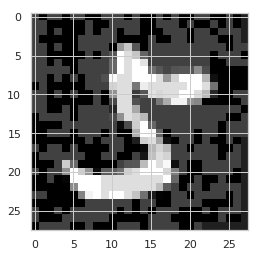

In [1330]:
adv_denorm = adv * std + mean
adv_data = adv.data.cpu().squeeze().numpy()
plt.imshow(adv_data, cmap='gray')

In [1331]:
np.argmax(fmodel.predictions(adversarial))

3

### Recon the adversarial attack

In [1332]:
mu_r, logvar_r = vae.encode(adv[0].unsqueeze(0).cuda())

In [1333]:
logvar_r.exp().mean()

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward1>)

In [1334]:
z_r = vae.reparameterize(mu_r, logvar_r)
rec_r = vae.decode(mu_r)

In [1335]:
find_prob(mu_r)

(array([0.39816048, 0.3915568 ]), -1.8585248212668164)

In [1336]:
rec_r = rec_r.view((1,28,28))

In [1337]:
i_r = rec_r.data.cpu().squeeze().numpy()

In [1338]:
bleh = np.expand_dims(i_r, 0)
np.argmax(fmodel.predictions(bleh))

3

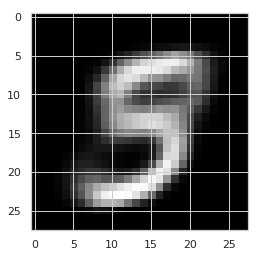

In [1339]:
plt.imshow(i_r, cmap='gray')

In [1340]:
diff = abs(i-i_r)

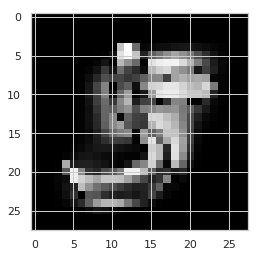

In [1341]:
plt.imshow(diff.squeeze(), cmap='gray')

In [1342]:
def compute_kld(mu, log_var):
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return KLD

## Carlini-Wagner-L2

In [628]:
choice_attack = 'cw'

In [629]:
if choice_attack == 'fgsm':
    attack = foolbox.attacks.FGSM(fmodel)
elif choice_attack == 'lbfgs':
    attack = foolbox.attacks.LBFGSAttack(fmodel)
elif choice_attack == 'cw':
    attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)

In [630]:
itr =iter(c_test_loader)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
l_count = 0
l_orig_prob_scores = []
l_adv_prob_scores = []
l_orig_labels = []
l_adv_labels = []
l_orig_vars = []
l_adv_vars = []
l_orig_recon_labels = []
l_adv_recon_labels = []
l_orig_klds = []
l_adv_klds = []

l_count_var = 0
l_count_kld = 0

pbar = tqdm(total=len(c_test_loader) * args.test_batch_size)
for i, (imgs, lbls) in enumerate(c_test_loader):
    #print(i)
    #imgs, lbls = itr.next()
    for j in range(len(imgs)):
        #print(i,j)
        img, lbl = imgs[j], lbls[j]
        #print(img.shape)
        #img, lbl = img.numpy(), lbl.numpy()
        img_denorm = img * std + mean
        mu, logvar = vae.encoder(img_denorm.view(-1, 784).cuda())
        _, prob = find_prob(mu)
        # Attack
        #print(img.shape, img)
        adversarial = attack(input_or_adv=img_denorm.numpy(), label=lbl.numpy())
        #print('adversarial class', np.argmax(fmodel.predictions(adversarial)))
        if adversarial is not None:
            # Get recon pred
            z = vae.sampling(mu, logvar)
            rec = vae.decoder(z)
            rec = rec.view((1,28,28))
            rec = rec.data.cpu().numpy()
            l_orig_recon_labels.append(np.argmax(fmodel.predictions(rec)))
            l_orig_klds.append(compute_kld(mu, logvar))
            adv = torch.Tensor(adversarial).unsqueeze(0)
            #print(adv)
            #adv_denorm = adv*std + mean
            adv_denorm = adv
            mu_a, logvar_a = vae.encoder(adv_denorm.view(-1, 784).cuda())
            l_adv_klds.append(compute_kld(mu_a, logvar_a))
            # Get adv rec pred
            z_a = vae.sampling(mu, logvar)
            rec_a = vae.decoder(z_a)
            rec_a = rec_a.view((1,28,28))
            rec_a = rec_a.data.cpu().numpy()
            l_adv_recon_labels.append(np.argmax(fmodel.predictions(rec_a)))
            #print(mu, mu_a)
            _, prob_a = find_prob(mu_a)
            # Collect the prob scores
            l_orig_prob_scores.append(prob)
            l_adv_prob_scores.append(prob_a)
            l_orig_labels.append(lbl)
            l_orig_vars.append(logvar.exp().mean().item())
            l_adv_vars.append(logvar_a.exp().mean().item())
            l_adv_labels.append(np.argmax(fmodel.predictions(adversarial)))
            if prob_a < prob:
                l_count += 1
            if adv_vars[-1] < orig_vars[-1]:
                l_count_var += 1
                #print(count, ":", "Actual:", prob, "Adv:", prob_a, "Label:", lbl.item(), "Adversary Label:", np.argmax(fmodel.predictions(adversarial)))
        pbar.update(1)
pbar.close()

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


In [631]:
print("NUMBER OF ADV PROB < ACTUAL PROB:", l_count)
print("NUMBER OF ADV VAR < ACTUAL VAR:", l_count_var)
print("NUMBER OF ADV KLD < ACTUAL KLD:", l_count_kld)
print("Orig Recon Pred == Adversarial Recon Pred:", np.sum(np.array(l_orig_recon_labels) == np.array(l_adv_recon_labels)))

NUMBER OF ADV PROB < ACTUAL PROB: 969
NUMBER OF ADV VAR < ACTUAL VAR: 10000
NUMBER OF ADV KLD < ACTUAL KLD: 0
Orig Recon Pred == Adversarial Recon Pred: 9696


In [632]:
print("Orig Label == Adversarial Recon Pred:", np.sum(np.array(l_orig_labels) == np.array(l_adv_recon_labels)))

Orig Label == Adversarial Recon Pred: 9540


In [633]:
print("Orig Label == Orig Recon Pred:", np.sum(np.array(l_orig_labels) == np.array(l_orig_recon_labels)))

Orig Label == Orig Recon Pred: 9552


## LBFGS

In [967]:
choice_attack = 'lbfgs'

In [968]:
if choice_attack == 'fgsm':
    attack = foolbox.attacks.FGSM(fmodel)
elif choice_attack == 'lbfgs':
    attack = foolbox.attacks.LBFGSAttack(fmodel)

In [ ]:
itr =iter(c_test_loader)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
l_count = 0
l_orig_prob_scores = []
l_adv_prob_scores = []
l_orig_labels = []
l_adv_labels = []
l_orig_vars = []
l_adv_vars = []
l_orig_recon_labels = []
l_adv_recon_labels = []
l_orig_klds = []
l_adv_klds = []

l_cosine_mu = []

l_count_var = 0
l_count_kld = 0

l_multi_orig_recon_preds, l_multi_orig_recon_scores = [], []
l_multi_adv_recon_preds, l_multi_adv_recon_scores = [], []

l_multi_orig_recon_loss = []
l_multi_adv_recon_loss = []

MULTI_K = 10

pbar = tqdm(total=len(c_test_loader) * args.test_batch_size)

vae = vae.cpu()

cnt = 0

for i, (imgs, lbls) in enumerate(c_test_loader):
    #print(i)
    #imgs, lbls = itr.next()
    cnt += 1
    for j in range(len(imgs)):
        #print(i,j)
        img, lbl = imgs[j], lbls[j]
        #print(img.shape)
        #img, lbl = img.numpy(), lbl.numpy()
        img_denorm = img * std + mean
        mu, logvar = vae.encode(img_denorm.unsqueeze(0))
        _, prob = find_prob(mu)
        # Attack
        #print(img.shape, img)
        adversarial = attack(input_or_adv=img_denorm.numpy(), label=lbl.numpy())
        #print('adversarial class', np.argmax(fmodel.predictions(adversarial)))
        if adversarial is not None:
            # Get recon pred
            #z = vae.sampling(mu, logvar)
            z = mu
            rec = vae.decode(z)
            rec = rec.view((1,28,28))
            rec = rec.data.cpu().numpy()
            l_orig_recon_labels.append(np.argmax(fmodel.predictions(rec)))
            kld = compute_kld(mu, logvar)
            l_orig_klds.append(kld)
            # Multi gen stuff
            mult_scores = []
            mult_preds = []
            rec_loss = []
            for _ in range(MULTI_K):
                zz = vae.reparameterize(mu, logvar)
                rrec = vae.decode(zz).view((1,28,28))
                rrec_num = rrec.data.cpu().numpy()
                pred = fmodel.predictions(rrec_num)
                mult_preds.append(np.argmax(pred))
                mult_scores.append(softmax(pred))
                rec_loss.append(F.mse_loss(rrec.view(-1,784).cpu(), img_denorm.view(-1, 784).cpu()).item())
                
            l_multi_orig_recon_preds.append(mult_preds)
            l_multi_orig_recon_scores.append(mult_scores)
            l_multi_orig_recon_loss.append(np.mean(rec_loss))
            # Generate Adversary
            adv = torch.Tensor(adversarial).unsqueeze(0)
            #print(adv)
            #adv_denorm = adv*std + mean
            adv_denorm = adv
            mu_a, logvar_a = vae.encode(adv_denorm)
            
            # Same Mult
            
            mult_adv_scores = []
            mult_adv_preds = []
            adv_rec_loss = []
            for _ in range(MULTI_K):
                zz_a = vae.reparameterize(mu_a, logvar_a)
                rrec_a = vae.decode(zz_a).view((1,28,28))
                rrec_a_num = rrec_a.data.cpu().numpy()
                pred_a = fmodel.predictions(rrec_a_num)
                mult_adv_preds.append(np.argmax(pred_a))
                mult_adv_scores.append(softmax(pred_a))
                adv_rec_loss.append(F.mse_loss(rrec_a.view(-1,784).cpu(), adv_denorm.view(-1, 784).cpu()).item())
                
            l_multi_adv_recon_preds.append(mult_adv_preds)
            l_multi_adv_recon_scores.append(mult_adv_scores)
            l_multi_adv_recon_loss.append(np.mean(adv_rec_loss))
            
            kld_a = compute_kld(mu_a, logvar_a)
            adv_klds.append(kld_a)
            # Get adv rec pred
            #z_a = vae.sampling(mu, logvar)
            z_a = mu_a
            rec_a = vae.decode(z_a)
            rec_a = rec_a.view((1,28,28))
            rec_a = rec_a.data.cpu().numpy()
            l_adv_recon_labels.append(np.argmax(fmodel.predictions(rec_a)))
            #print(mu, mu_a)
            _, prob_a = find_prob(mu_a)
            # Collect the prob scores
            l_orig_prob_scores.append(prob)
            l_adv_prob_scores.append(prob_a)
            l_orig_labels.append(lbl)
            l_orig_vars.append(logvar.exp().mean().item())
            l_adv_vars.append(logvar_a.exp().mean().item())
            l_adv_labels.append(np.argmax(fmodel.predictions(adversarial)))
            l_cosine_mu.append(cosine(mu.data.cpu().numpy(), mu_a.data.cpu().numpy()))
            if prob_a < prob:
                l_count += 1
            if adv_vars[-1] < orig_vars[-1]:
                l_count_var += 1
            if adv_klds[-1] < orig_klds[-1]:
                l_count_kld += 1
                #print(count, ":", "Actual:", prob, "Adv:", prob_a, "Label:", lbl.item(), "Adversary Label:", np.argmax(fmodel.predictions(adversarial)))
        pbar.update(1)
        #if cnt >= 5:
        #    break
pbar.close()

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: GradientAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


## Can multi-recon loss be used to detect LBFGS attacked digits as anomalies?

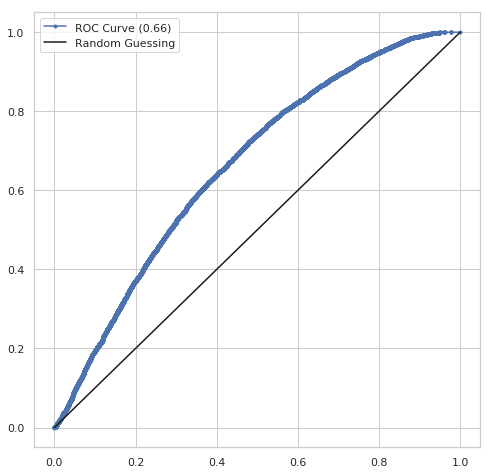

In [1273]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([l_multi_orig_recon_loss, l_multi_adv_recon_loss],0)
true_label = [0]*len(l_multi_orig_recon_loss)+[1]*len(l_multi_adv_recon_loss)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

In [985]:
l_orig_labels = np.array(l_orig_labels)
l_orig_recon_labels = np.array(l_orig_recon_labels)
l_adv_recon_labels = np.array(l_adv_recon_labels)

In [986]:
print(np.sum(l_orig_labels == l_orig_recon_labels))
print(np.sum(l_orig_labels == l_adv_recon_labels))
#print(np.sum(orig_recon_labels == adv_recon_labels))

9778
9252


In [987]:
l_orig_count = 0
l_adv_count = 0
for i in range(len(l_orig_labels)):
    recon_pred = np.bincount(l_multi_orig_recon_preds[i]).argmax()
    if recon_pred == l_orig_labels[i]:
        l_orig_count += 1
    adv_pred = np.bincount(l_multi_adv_recon_preds[i]).argmax()
    if adv_pred == l_orig_labels[i]:
        l_adv_count += 1
print(l_orig_count, l_adv_count)

9764 9229


In [988]:
orig_var = []
adv_var = []
for i in range(len(orig_labels)):
    orig_var.append(len(np.unique(multi_orig_recon_preds[i])))
    adv_var.append(len(np.unique(multi_adv_recon_preds[i])))

print(np.mean(orig_var), np.mean(adv_var))

1.0722288915566227 1.4795918367346939


In [966]:
orig_score = []
adv_score = []
for i in range(len(orig_labels)):
    orig_score.append(np.mean(np.var(multi_orig_recon_scores[i], axis=1), axis=0))
    adv_score.append(np.mean(np.var(multi_adv_recon_scores[i], axis=1), axis=0))
    #orig_score.append()

print(np.mean(orig_score), np.mean(adv_score))

0.08824637 0.081163175


In [1209]:
l_orig_var = []
l_adv_var = []
for i in range(len(orig_labels)):
    l_orig_var.append(len(np.unique(l_multi_orig_recon_preds[i])))
    l_adv_var.append(len(np.unique(l_multi_adv_recon_preds[i])))

print(np.mean(l_orig_var), np.mean(l_adv_var))
print(np.std(l_orig_var), np.std(l_adv_var))

1.0738295318127251 1.2869147659063624
0.28945620482211964 0.5047918096071625


In [1210]:
np.bincount(l_orig_var)

array([   0, 9329,  602,   59,    6])

In [1211]:
np.unique(l_orig_var)

array([1, 2, 3, 4])

In [1212]:
np.unique(l_adv_var)

array([1, 2, 3, 4, 5])

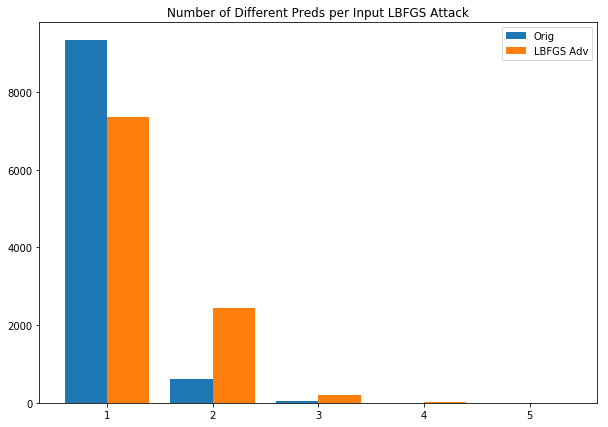

In [1216]:
plt.figure(figsize=(10,7))
plt.bar(np.unique(adv_var)-0.2, list(np.bincount(l_orig_var)[1:])+[0], width=0.4, label='Orig');
plt.bar(np.unique(adv_var)+0.2, np.bincount(l_adv_var)[1:], width=0.4, label='LBFGS Adv');
plt.title('Number of Different Preds per Input LBFGS Attack');
plt.legend();

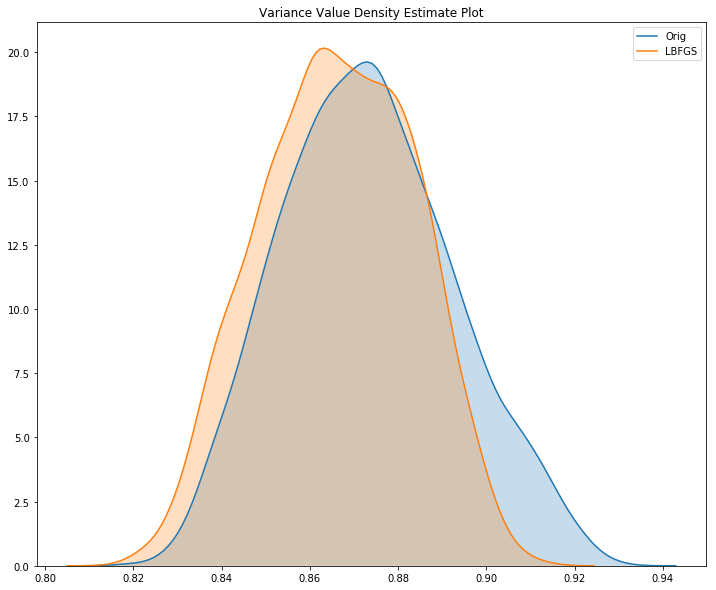

In [1218]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(l_orig_vars, shade=True, label='Orig');
sns.kdeplot(l_adv_vars, shade=True, label='LBFGS');
plt.title('Variance Value Density Estimate Plot');

In [1140]:
import seaborn as sns

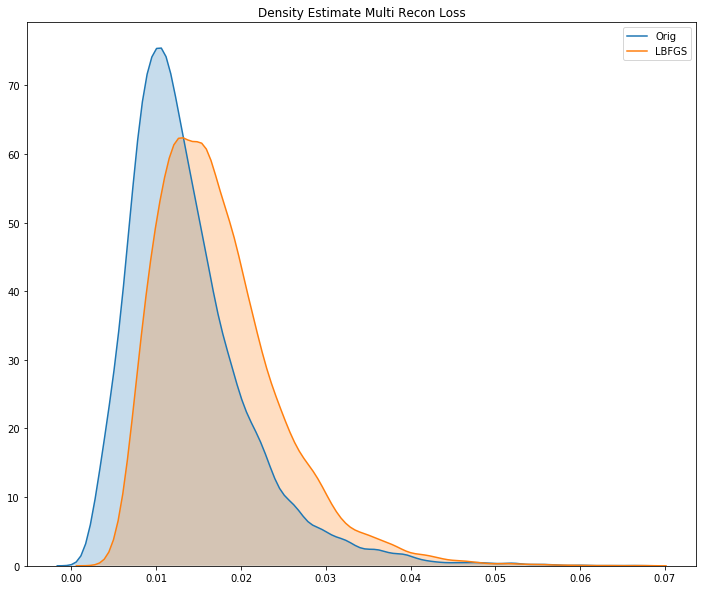

In [1224]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(l_multi_orig_recon_loss, shade=True, label='Orig');
sns.kdeplot(l_multi_adv_recon_loss, shade=True, label='LBFGS');
plt.title('Density Estimate Multi Recon Loss');

In [382]:
print("NUMBER OF ADV PROB < ACTUAL PROB:", l_count)
print("NUMBER OF ADV VAR < ACTUAL VAR:", l_count_var)
print("NUMBER OF ADV KLD < ACTUAL KLD:", l_count_kld)
print("Orig Recon Pred == Adversarial Recon Pred:", np.sum(np.array(l_orig_recon_labels) == np.array(l_adv_recon_labels)))

NUMBER OF ADV PROB < ACTUAL PROB: 182
NUMBER OF ADV VAR < ACTUAL VAR: 10000
NUMBER OF ADV KLD < ACTUAL KLD: 0
Orig Recon Pred == Adversarial Recon Pred: 9728


In [383]:
print("Orig Label == Adversarial Recon Pred:", np.sum(np.array(l_orig_labels) == np.array(l_adv_recon_labels)))

Orig Label == Adversarial Recon Pred: 9563


In [384]:
print("Orig Label == Orig Recon Pred:", np.sum(np.array(l_orig_labels) == np.array(l_orig_recon_labels)))

Orig Label == Orig Recon Pred: 9541


### Predictions of Orig, Recon and Adversaries

In [431]:
l_cnt = 0
for i in range(len(l_orig_labels)):
    if l_orig_labels[i] == l_orig_recon_labels[i] and l_orig_recon_labels[i] == l_adv_recon_labels[i]:
        l_cnt += 1
print(l_cnt)

9434


In [432]:
f_cnt = 0
for i in range(len(orig_labels)):
    if orig_labels[i] == orig_recon_labels[i] and orig_recon_labels[i] == adv_recon_labels[i]:
        f_cnt += 1
print(f_cnt)

9427


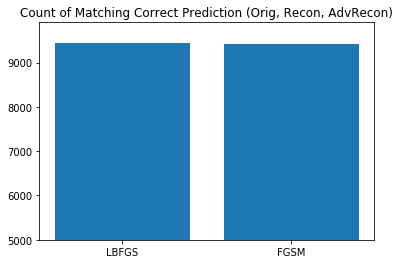

In [433]:
plt.bar(range(2), [l_cnt, f_cnt])
plt.xticks(range(2), labels=['LBFGS', 'FGSM'])
plt.title('Count of Matching Correct Prediction (Orig, Recon, AdvRecon)');
plt.ylim(bottom=5000);

### Variance and the Labels

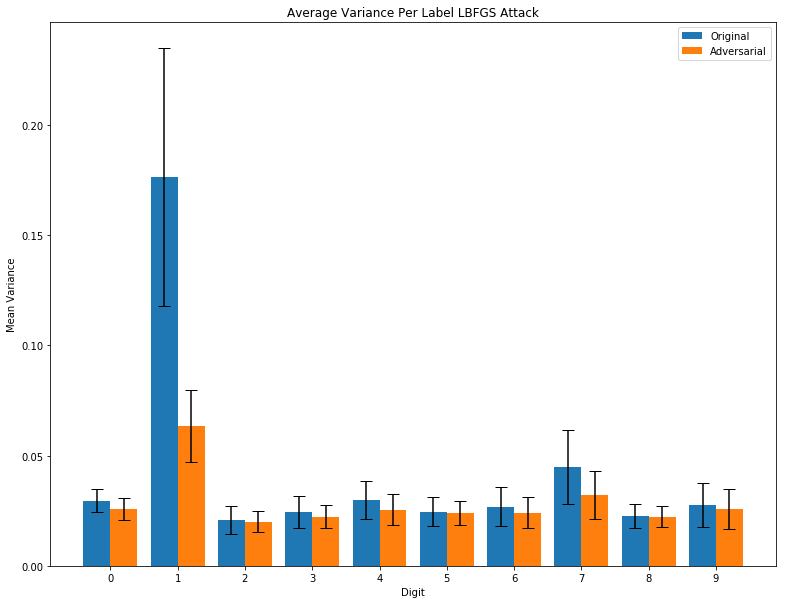

In [401]:
l_orig_vars = np.array(l_orig_vars)
l_adv_vars = np.array(l_adv_vars)
l_orig_labels = np.array(l_orig_labels)
mean_orig_var_list = []
mean_orig_std = []
mean_adv_var_list = []
mean_adv_std = []
for i in range(10):
    var = l_orig_vars[l_orig_labels == i]
    var_adv = l_adv_vars[l_orig_labels == i]
    mean_orig_var_list.append(np.mean(var))
    mean_orig_std.append(np.std(var))
    mean_adv_var_list.append(np.mean(var_adv))
    mean_adv_std.append(np.std(var_adv))

plt.figure(figsize=(13,10))
ax = plt.subplot(1,1,1);
plt.bar(np.arange(10) - 0.2, mean_orig_var_list, yerr=mean_orig_std, width=0.4, align='center', label='Original', capsize=6);
#plt.subplot(2,1,2)
plt.bar(np.arange(10) + 0.2, mean_adv_var_list, yerr=mean_adv_std, width=0.4, align='center', label='Adversarial', capsize=6);
plt.xticks(range(10))
plt.legend()
plt.ylabel('Mean Variance')
plt.xlabel('Digit')
plt.title('Average Variance Per Label '+'LBFGS Attack');

### Negative LogProb and the Labels

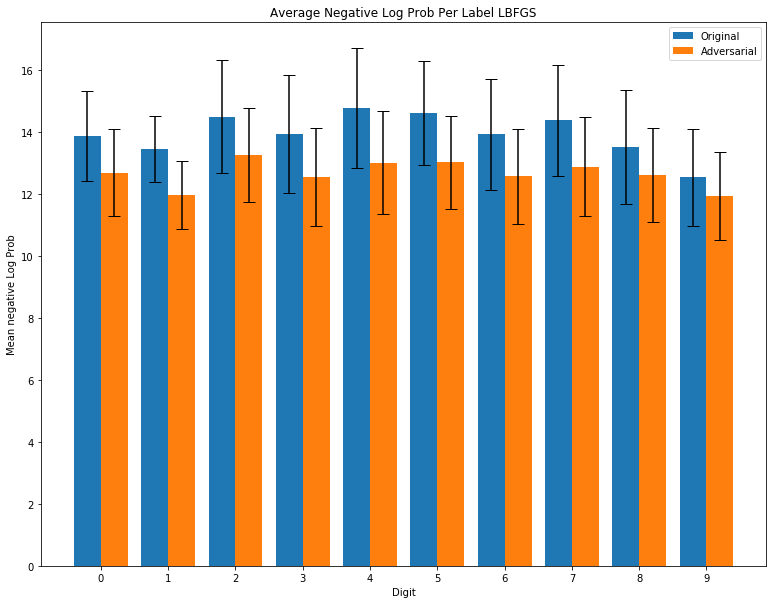

In [283]:
l_orig_prob_scores = np.array(l_orig_prob_scores)
l_adv_prob_scores = np.array(l_adv_prob_scores)
mean_orig_prob_list = []
mean_orig_std = []
mean_adv_prob_list = []
mean_adv_std = []
for i in range(10):
    var = -1.0 * l_orig_prob_scores[l_orig_labels == i]
    var_adv = -1.0 * l_adv_prob_scores[l_orig_labels == i]
    mean_orig_prob_list.append(np.mean(var))
    mean_orig_std.append(np.std(var))
    mean_adv_prob_list.append(np.mean(var_adv))
    mean_adv_std.append(np.std(var_adv))

plt.figure(figsize=(13,10))
ax = plt.subplot(1,1,1);
plt.bar(np.arange(10) - 0.2, mean_orig_prob_list, yerr=mean_orig_std, width=0.4, align='center', label='Original', capsize=6);
#plt.subplot(2,1,2)
plt.bar(np.arange(10) + 0.2, mean_adv_prob_list, yerr=mean_adv_std, width=0.4, align='center', label='Adversarial', capsize=6);
plt.xticks(range(10))
plt.legend()
plt.ylabel('Mean negative Log Prob')
plt.xlabel('Digit')
plt.title('Average Negative Log Prob Per Label LBFGS');

### OTher

In [352]:
l_orig_prob_scores, l_adv_prob_scores = np.array(l_orig_prob_scores), np.array(l_adv_prob_scores)

In [353]:
l_idx = l_adv_prob_scores < l_orig_prob_scores

In [354]:
l_orig_labels, l_adv_labels = np.array(l_orig_labels), np.array(l_adv_labels)

In [355]:
l_filt_orig_labels = l_orig_labels[l_idx]

In [356]:
np.bincount(l_filt_orig_labels)

array([14,  3,  8, 31,  0,  9, 13,  4, 20, 82])

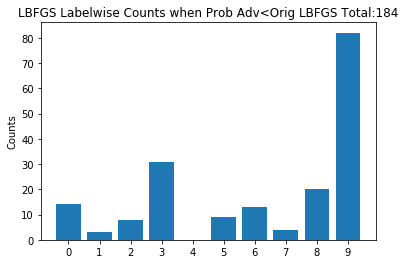

In [357]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(l_filt_orig_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('LBFGS Labelwise Counts when Prob Adv<Orig LBFGS Total:'+str(np.sum(np.bincount(l_filt_orig_labels))));

In [104]:
l_idx = l_adv_prob_scores > l_orig_prob_scores

In [105]:
l_orig_labels, l_adv_labels = np.array(l_orig_labels), np.array(l_adv_labels)

In [106]:
l_filt_orig_labels = l_orig_labels[l_idx]

In [107]:
np.bincount(l_filt_orig_labels)

array([ 963, 1127, 1016,  976,  975,  865,  927, 1006,  944,  909])

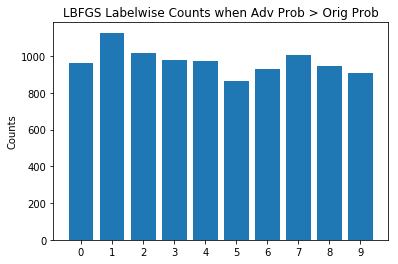

In [108]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(l_filt_orig_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('LBFGS Labelwise Counts when Adv Prob > Orig Prob');

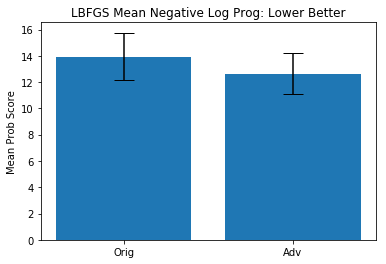

In [161]:
l_mean_scores = [-1*np.mean(l_orig_prob_scores), -1*np.mean(l_adv_prob_scores)]
l_std_scores = [np.std(l_orig_prob_scores), np.std(l_adv_prob_scores)]
plt.bar(range(len(l_mean_scores)), l_mean_scores, yerr=l_std_scores, capsize=10)
plt.xticks([0,1], ['Orig', 'Adv'])
plt.ylabel('Mean Prob Score')
plt.title('LBFGS Mean Negative Log Prog: Lower Better');
#plt.ylim((13,14))

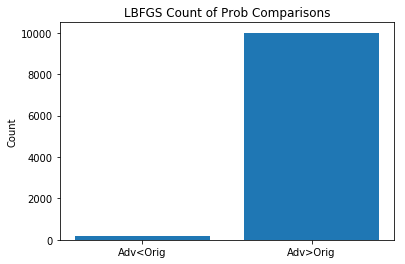

In [111]:
l_mean_scores = [l_count, len(l_orig_prob_scores)]
plt.bar(range(len(l_mean_scores)), l_mean_scores)
plt.xticks([0,1], ['Adv<Orig', 'Adv>Orig'])
plt.ylabel('Count')
plt.title('LBFGS Count of Prob Comparisons');
#plt.ylim((13,14))

In [112]:
np.bincount(l_adv_labels)

array([ 312,  204, 1040, 2724,  673,  686,  276,  869, 1971, 1245])

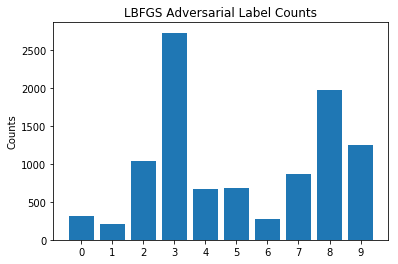

In [113]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(l_adv_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('LBFGS Adversarial Label Counts');

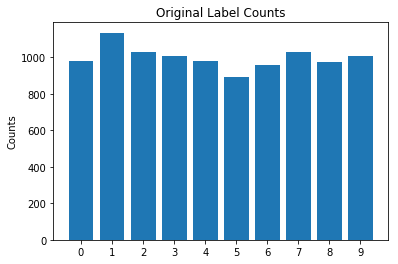

In [114]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(l_orig_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('Original Label Counts');

(0, 0.10223292584186179)

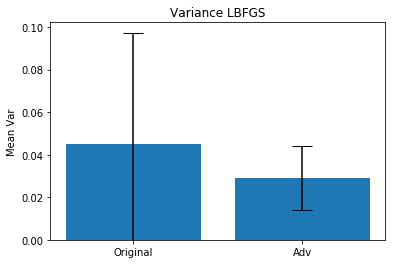

In [164]:
l_mean_scores = [np.mean(l_orig_vars), np.mean(l_adv_vars)]
l_mean_std = [np.std(l_orig_vars), np.std(l_adv_vars)]
plt.bar(range(len(l_mean_scores)), l_mean_scores, yerr=l_mean_std, capsize=10)
plt.xticks([0,1], ['Original', 'Adv'])
plt.ylabel('Mean Var')
plt.title('Variance LBFGS');
plt.ylim(bottom=0)

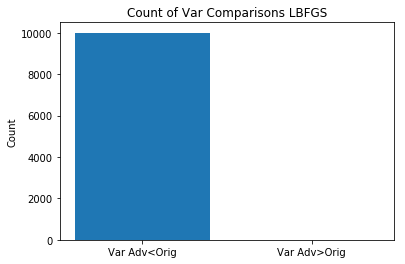

In [116]:
l_mean_scores = [l_count_var, len(l_orig_prob_scores) - l_count_var]
plt.bar(range(len(l_mean_scores)), l_mean_scores)
plt.xticks([0,1], ['Var Adv<Orig', 'Var Adv>Orig'])
plt.ylabel('Count')
plt.title('Count of Var Comparisons LBFGS');
#plt.ylim((13,14))

## FGSM

In [1343]:
from scipy.spatial.distance import cosine

In [1344]:
choice_attack = 'fgsm'

In [1345]:
if choice_attack == 'fgsm':
    attack = foolbox.attacks.FGSM(fmodel)
elif choice_attack == 'lbfgs':
    attack = foolbox.attacks.LBFGSAttack(fmodel)

In [1346]:
from scipy.special import softmax

In [ ]:
itr =iter(c_test_loader)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
count = 0
orig_prob_scores = []
adv_prob_scores = []
orig_labels = []
adv_labels = []
orig_vars = []
adv_vars = []
orig_recon_labels = []
adv_recon_labels = []
orig_klds = []
adv_klds = []

cosine_mu = []

count_var = 0
count_kld = 0

multi_orig_recon_preds, multi_orig_recon_scores = [], []
multi_adv_recon_preds, multi_adv_recon_scores = [], []

multi_orig_recon_loss = []
multi_adv_recon_loss = []

MULTI_K = 10

pbar = tqdm(total=len(c_test_loader) * args.test_batch_size)

vae = vae.cpu()

cnt = 0

for i, (imgs, lbls) in enumerate(c_test_loader):
    #print(i)
    #imgs, lbls = itr.next()
    cnt += 1
    for j in range(len(imgs)):
        #print(i,j)
        img, lbl = imgs[j], lbls[j]
        #print(img.shape)
        #img, lbl = img.numpy(), lbl.numpy()
        img_denorm = img * std + mean
        mu, logvar = vae.encode(img_denorm.unsqueeze(0))
        _, prob = find_prob(mu)
        # Attack
        #print(img.shape, img)
        adversarial = attack(input_or_adv=img_denorm.numpy(), label=lbl.numpy())
        #print('adversarial class', np.argmax(fmodel.predictions(adversarial)))
        if adversarial is not None:
            # Get recon pred
            #z = vae.sampling(mu, logvar)
            z = mu
            rec = vae.decode(z)
            rec = rec.view((1,28,28))
            rec = rec.data.cpu().numpy()
            orig_recon_labels.append(np.argmax(fmodel.predictions(rec)))
            kld = compute_kld(mu, logvar)
            orig_klds.append(kld)
            # Multi gen stuff
            mult_scores = []
            mult_preds = []
            rec_loss = []
            for _ in range(MULTI_K):
                zz = vae.reparameterize(mu, logvar)
                rrec = vae.decode(zz).view((1,28,28))
                rrec_num = rrec.data.cpu().numpy()
                pred = fmodel.predictions(rrec_num)
                mult_preds.append(np.argmax(pred))
                mult_scores.append(softmax(pred))
                rec_loss.append(F.mse_loss(rrec.view(-1,784).cpu(), img_denorm.view(-1, 784).cpu()).item())
                
            multi_orig_recon_preds.append(mult_preds)
            multi_orig_recon_scores.append(mult_scores)
            multi_orig_recon_loss.append(np.mean(rec_loss))
            # Generate Adversary
            adv = torch.Tensor(adversarial).unsqueeze(0)
            #print(adv)
            #adv_denorm = adv*std + mean
            adv_denorm = adv
            mu_a, logvar_a = vae.encode(adv_denorm)
            
            # Same Mult
            
            mult_adv_scores = []
            mult_adv_preds = []
            adv_rec_loss = []
            for _ in range(MULTI_K):
                zz_a = vae.reparameterize(mu_a, logvar_a)
                rrec_a = vae.decode(zz_a).view((1,28,28))
                rrec_a_num = rrec_a.data.cpu().numpy()
                pred_a = fmodel.predictions(rrec_a_num)
                mult_adv_preds.append(np.argmax(pred_a))
                mult_adv_scores.append(softmax(pred_a))
                adv_rec_loss.append(F.mse_loss(rrec_a.view(-1,784).cpu(), adv_denorm.view(-1, 784).cpu()).item())
                
            multi_adv_recon_preds.append(mult_adv_preds)
            multi_adv_recon_scores.append(mult_adv_scores)
            multi_adv_recon_loss.append(np.mean(adv_rec_loss))
            
            kld_a = compute_kld(mu_a, logvar_a)
            adv_klds.append(kld_a)
            # Get adv rec pred
            #z_a = vae.sampling(mu, logvar)
            z_a = mu_a
            rec_a = vae.decode(z_a)
            rec_a = rec_a.view((1,28,28))
            rec_a = rec_a.data.cpu().numpy()
            adv_recon_labels.append(np.argmax(fmodel.predictions(rec_a)))
            #print(mu, mu_a)
            _, prob_a = find_prob(mu_a)
            # Collect the prob scores
            orig_prob_scores.append(prob)
            adv_prob_scores.append(prob_a)
            orig_labels.append(lbl)
            orig_vars.append(logvar.exp().mean().item())
            adv_vars.append(logvar_a.exp().mean().item())
            adv_labels.append(np.argmax(fmodel.predictions(adversarial)))
            cosine_mu.append(cosine(mu.data.cpu().numpy(), mu_a.data.cpu().numpy()))
            if prob_a < prob:
                count += 1
            if adv_vars[-1] < orig_vars[-1]:
                count_var += 1
            if adv_klds[-1] < orig_klds[-1]:
                count_kld += 1
                #print(count, ":", "Actual:", prob, "Adv:", prob_a, "Label:", lbl.item(), "Adversary Label:", np.argmax(fmodel.predictions(adversarial)))
        pbar.update(1)
        #if cnt >= 5:
        #    break
pbar.close()

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack becaus

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack becaus

## Can multi-recon loss be used to detect FGSM attacked digits as anomalies?

In [938]:
orig_labels = np.array(orig_labels)
orig_recon_labels = np.array(orig_recon_labels)
adv_recon_labels = np.array(adv_recon_labels)

In [944]:
print(np.sum(orig_labels == orig_recon_labels))
print(np.sum(orig_labels == adv_recon_labels))
#print(np.sum(orig_recon_labels == adv_recon_labels))

9774
8365


In [945]:
orig_count = 0
adv_count = 0
for i in range(len(orig_labels)):
    recon_pred = np.bincount(multi_orig_recon_preds[i]).argmax()
    if recon_pred == orig_labels[i]:
        orig_count += 1
    adv_pred = np.bincount(multi_adv_recon_preds[i]).argmax()
    if adv_pred == orig_labels[i]:
        adv_count += 1
print(orig_count, adv_count)

9765 8230


In [1177]:
orig_var = []
adv_var = []
for i in range(len(orig_labels)):
    orig_var.append(len(np.unique(multi_orig_recon_preds[i])))
    adv_var.append(len(np.unique(multi_adv_recon_preds[i])))

print(np.mean(orig_var), np.mean(adv_var))
print(np.std(orig_var), np.std(adv_var))

1.0722288915566227 1.4795918367346939
0.28743368153040644 0.6773973873270628


In [1199]:
np.bincount(orig_var)

array([   0, 9348,  578,   66,    4])

In [1200]:
np.unique(orig_var)

array([1, 2, 3, 4])

NameError: name 'l_adv_var' is not defined

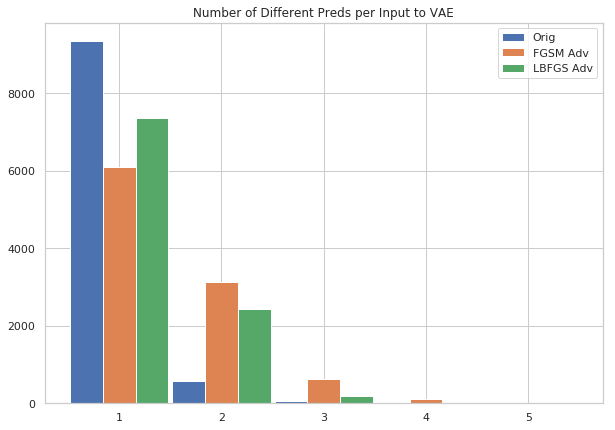

In [1277]:
plt.figure(figsize=(10,7))
plt.bar(1.25*np.unique(adv_var)-0.4, list(np.bincount(orig_var)[1:])+[0], width=0.4, label='Orig');
plt.bar(1.25*np.unique(adv_var), np.bincount(adv_var)[1:], width=0.4, label='FGSM Adv');
plt.bar(1.25*np.unique(adv_var)+0.4, np.bincount(l_adv_var)[1:], width=0.4, label='LBFGS Adv');
plt.title('Number of Different Preds per Input to VAE');
plt.xticks(1.25*np.unique(adv_var), np.unique(adv_var))
plt.legend();

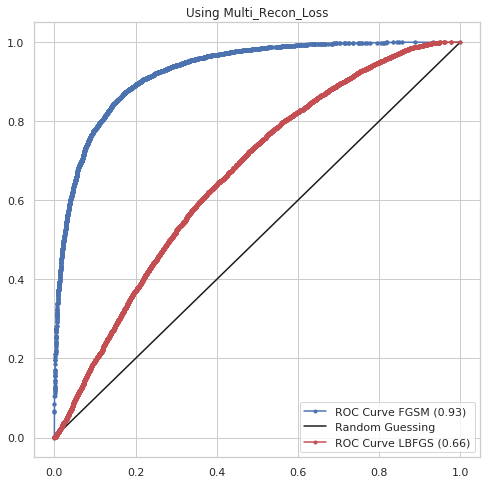

In [1285]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([multi_orig_recon_loss, multi_adv_recon_loss],0)

true_label = [0]*len(multi_orig_recon_loss)+[1]*len(multi_adv_recon_loss)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve FGSM (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')

l_mse_score = np.concatenate([l_multi_orig_recon_loss, l_multi_adv_recon_loss],0)

l_true_label = [0]*len(l_multi_orig_recon_loss)+[1]*len(l_multi_adv_recon_loss)
if roc_auc_score(l_true_label, l_mse_score)<0.5:
    l_mse_score *= -1
l_fpr, l_tpr, l_thresholds = roc_curve(l_true_label, l_mse_score)
l_auc_score = roc_auc_score(l_true_label, l_mse_score)
ax1.plot(l_fpr, l_tpr, 'r.-', label = 'ROC Curve LBFGS (%2.2f)' %  l_auc_score)
ax1.set_title('Using Multi_Recon_Loss')
ax1.legend();

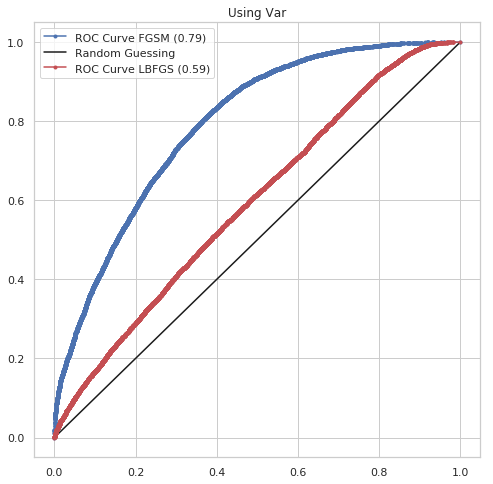

In [1286]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([orig_vars, adv_vars],0)

true_label = [0]*len(orig_vars)+[1]*len(adv_vars)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve FGSM (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')

l_mse_score = np.concatenate([l_orig_vars, l_adv_vars],0)

l_true_label = [0]*len(l_orig_vars)+[1]*len(l_adv_vars)
if roc_auc_score(l_true_label, l_mse_score)<0.5:
    l_mse_score *= -1
l_fpr, l_tpr, l_thresholds = roc_curve(l_true_label, l_mse_score)
l_auc_score = roc_auc_score(l_true_label, l_mse_score)
ax1.plot(l_fpr, l_tpr, 'r.-', label = 'ROC Curve LBFGS (%2.2f)' %  l_auc_score)
ax1.set_title('Using Var')
ax1.legend();

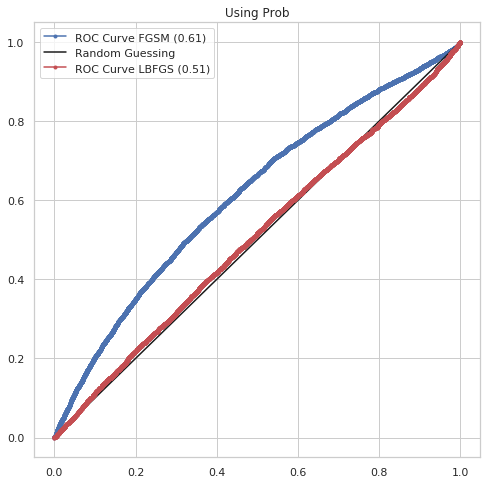

In [1289]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([orig_prob_scores, adv_prob_scores],0)

true_label = [0]*len(orig_prob_scores)+[1]*len(adv_prob_scores)
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve FGSM (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')

l_mse_score = np.concatenate([l_orig_prob_scores, l_adv_prob_scores],0)

l_true_label = [0]*len(l_orig_prob_scores)+[1]*len(l_adv_prob_scores)
if roc_auc_score(l_true_label, l_mse_score)<0.5:
    l_mse_score *= -1
l_fpr, l_tpr, l_thresholds = roc_curve(l_true_label, l_mse_score)
l_auc_score = roc_auc_score(l_true_label, l_mse_score)
ax1.plot(l_fpr, l_tpr, 'r.-', label = 'ROC Curve LBFGS (%2.2f)' %  l_auc_score)
ax1.set_title('Using Prob')
ax1.legend();

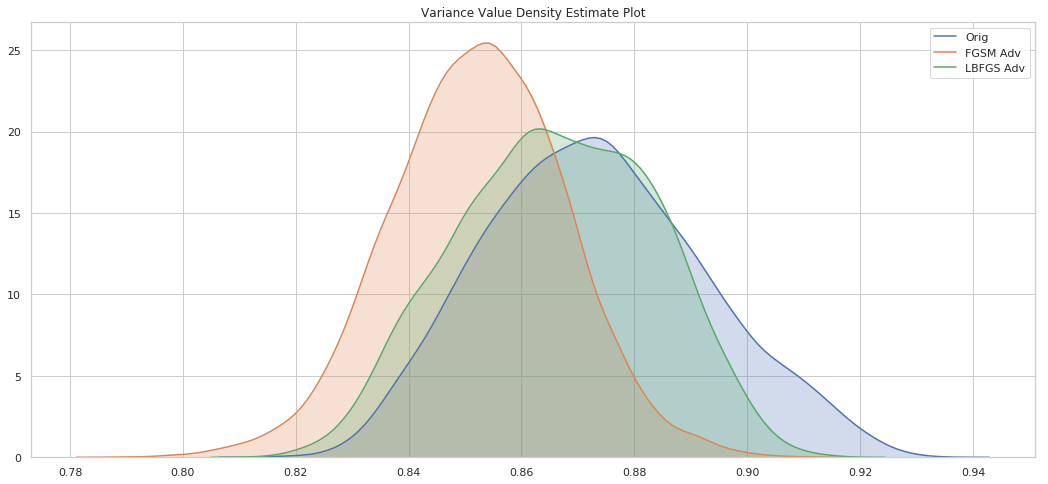

In [1293]:
plt.figure(figsize=(18,8));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(orig_vars, shade=True, label='Orig');
sns.kdeplot(adv_vars, shade=True, label='FGSM Adv');
sns.kdeplot(l_adv_vars, shade=True, label='LBFGS Adv');
plt.title('Variance Value Density Estimate Plot');

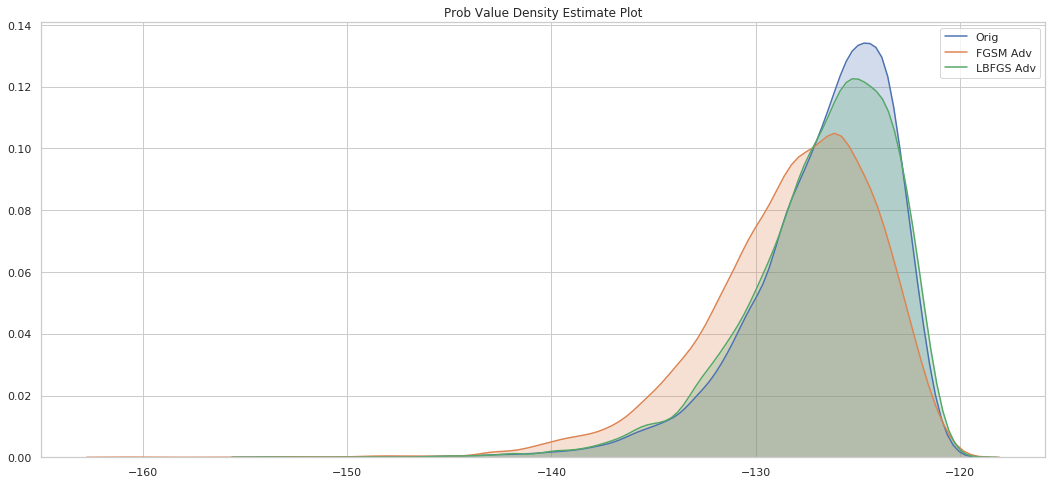

In [1292]:
plt.figure(figsize=(18,8));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(orig_prob_scores, shade=True, label='Orig');
sns.kdeplot(adv_prob_scores, shade=True, label='FGSM Adv');
sns.kdeplot(l_adv_prob_scores, shade=True, label='LBFGS Adv');
plt.title('Prob Value Density Estimate Plot');

In [1140]:
import seaborn as sns

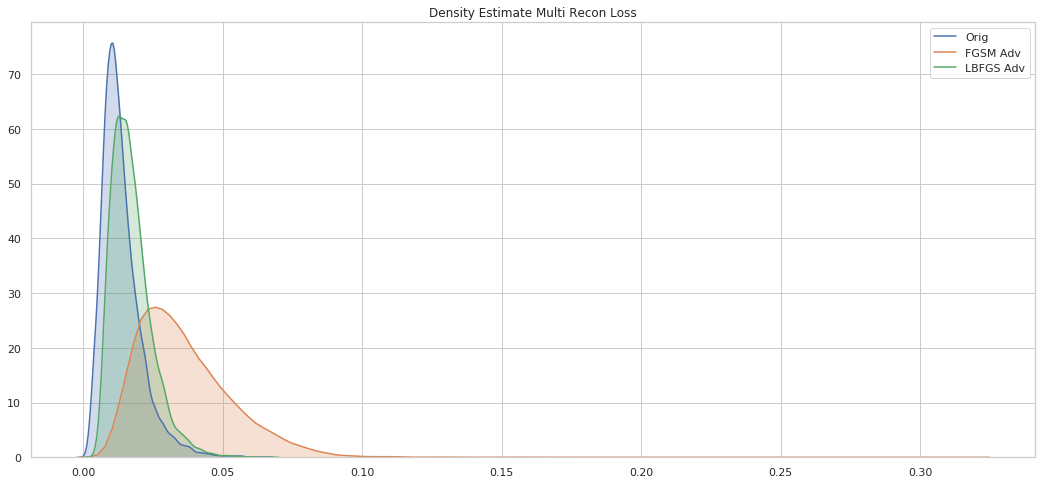

In [1291]:
plt.figure(figsize=(18,8));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(multi_orig_recon_loss, shade=True, label='Orig');
sns.kdeplot(multi_adv_recon_loss, shade=True, label='FGSM Adv');
sns.kdeplot(l_multi_adv_recon_loss, shade=True, label='LBFGS Adv');
plt.title('Density Estimate Multi Recon Loss');

## For each inp we get 10 generations and 10 preds. Get argmax and count of argmax. This will be confidence

In [1259]:
orig_conf = []
adv_conf = []
l_adv_conf = []
for i in range(len(orig_labels)):
    (values,counts) = np.unique(multi_orig_recon_preds[i],return_counts=True)
    orig_conf.append(counts[np.argmax(counts)] / len(multi_orig_recon_preds[i]))
    (values,counts) = np.unique(multi_adv_recon_preds[i],return_counts=True)
    adv_conf.append(counts[np.argmax(counts)] / len(multi_adv_recon_preds[i]))
    (values,counts) = np.unique(l_multi_adv_recon_preds[i],return_counts=True)
    l_adv_conf.append(counts[np.argmax(counts)] / len(l_multi_adv_recon_preds[i]))
    
print(np.mean(orig_conf), np.mean(adv_conf), np.mean(l_adv_conf))

0.9848639455782313 0.8966886754701882 0.9373149259703881


In [1260]:
import pandas as pd

In [1261]:
types = ['Orig' for _ in range(len(orig_conf))] + ['FGSM' for _ in range(len(adv_conf))] + ['LBFGS' for _ in range(len(l_adv_conf))]
vals = orig_conf + adv_conf + l_adv_conf

df1 = pd.DataFrame({'Type':types, 'Confidence': vals})

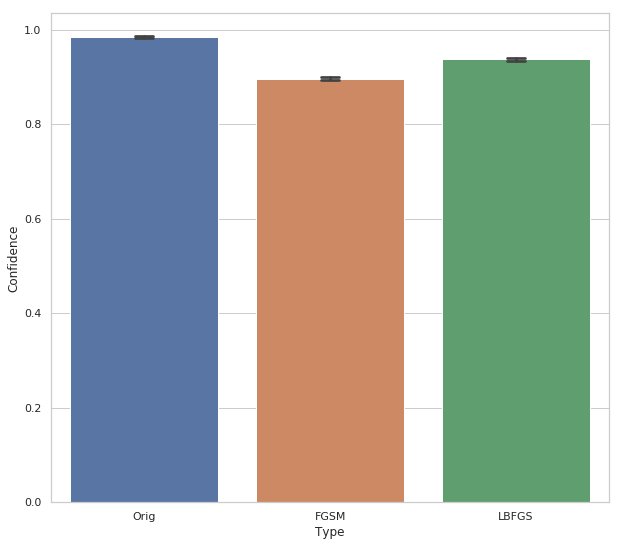

In [1262]:
plt.figure(figsize=(10,9))
sns.barplot(x='Type', y='Confidence', data=df1, capsize=0.1);


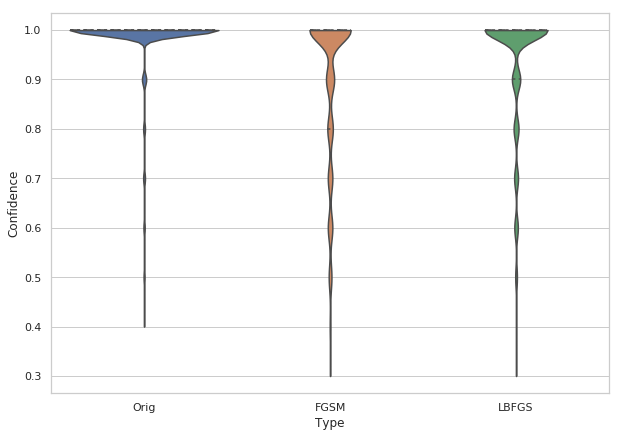

In [1282]:
plt.figure(figsize=(10,7))
sns.set(style="whitegrid")
sns.violinplot(data=df1, y='Confidence', x='Type', inner='quartile', cut=0);

In [979]:
orig_conf = []
adv_conf = []
for i in range(len(orig_labels)):
    (values,counts) = np.unique(multi_orig_recon_preds[i],return_counts=True)
    ix = np.argmax(counts)
    if values[ix] != orig_labels[i]:
        orig_conf.append(counts[ix] / len(multi_orig_recon_preds[i]))
    (values,counts) = np.unique(multi_adv_recon_preds[i],return_counts=True)
    ix = np.argmax(counts)
    if values[ix] != orig_labels[i]:
        adv_conf.append(counts[ix] / len(multi_adv_recon_preds[i]))
    
print(np.mean(orig_conf), np.mean(adv_conf))

0.781818181818182 0.7509060022650057


In [966]:
orig_score = []
adv_score = []
for i in range(len(orig_labels)):
    orig_score.append(np.mean(np.var(multi_orig_recon_scores[i], axis=1), axis=0))
    adv_score.append(np.mean(np.var(multi_adv_recon_scores[i], axis=1), axis=0))
    #orig_score.append()

print(np.mean(orig_score), np.mean(adv_score))

0.08824637 0.081163175


## Other Stuff

In [663]:
np.mean(cosine_mu), np.std(cosine_mu)

(0.4132600634699912, 0.32381094950179656)

In [664]:
print("NUMBER OF ADV PROB < ACTUAL PROB:", count)
print("NUMBER OF ADV VAR < ACTUAL VAR:", count_var)
print("NUMBER OF ADV KLD < ACTUAL KLD:", count_kld)
print("Orig Recon Pred == Adversarial Recon Pred:", np.sum(np.array(orig_recon_labels) == np.array(adv_recon_labels)))

NUMBER OF ADV PROB < ACTUAL PROB: 38
NUMBER OF ADV VAR < ACTUAL VAR: 9494
NUMBER OF ADV KLD < ACTUAL KLD: 5713
Orig Recon Pred == Adversarial Recon Pred: 3680


In [665]:
orig_prob_scores, adv_prob_scores = np.array(orig_prob_scores), np.array(adv_prob_scores)

In [666]:
idx = adv_prob_scores < orig_prob_scores

In [667]:
orig_labels, adv_labels = np.array(orig_labels), np.array(adv_labels)

In [668]:
filt_orig_labels = orig_labels[idx]

In [669]:
np.bincount(filt_orig_labels)

array([ 8,  1,  0,  6,  0,  0,  2,  0,  6, 15])

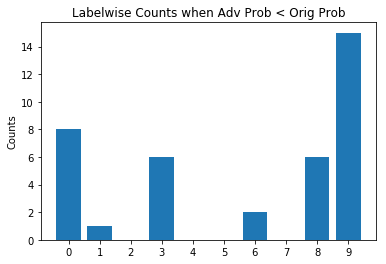

In [670]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(filt_orig_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('Labelwise Counts when Adv Prob < Orig Prob');

### Variance and the Labels

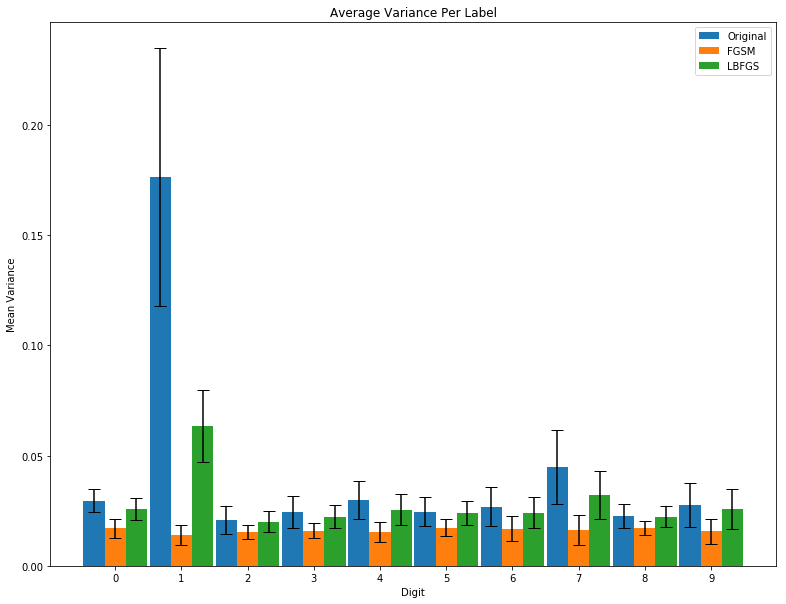

In [402]:
orig_vars = np.array(orig_vars)
adv_vars = np.array(adv_vars)
l_adv_vars = np.array(l_adv_vars)
l_orig_labels = np.array(l_orig_labels)
orig_labels = np.array(orig_labels)
mean_orig_var_list = []
mean_orig_std = []
mean_adv_var_list = []
mean_adv_std = []
l_mean_var_list = []
l_mean_std = []

for i in range(10):
    var = orig_vars[orig_labels == i]
    var_adv = adv_vars[orig_labels == i]
    l_var = l_adv_vars[l_orig_labels == i]
    mean_orig_var_list.append(np.mean(var))
    mean_orig_std.append(np.std(var))
    mean_adv_var_list.append(np.mean(var_adv))
    mean_adv_std.append(np.std(var_adv))
    l_mean_var_list.append(np.mean(l_var))
    l_mean_std.append(np.std(l_var))

plt.figure(figsize=(13,10))
ax = plt.subplot(1,1,1);
plt.bar(1.25*np.arange(10) - 0.4, mean_orig_var_list, yerr=mean_orig_std, width=0.4, align='center', label='Original', capsize=6);
#plt.subplot(2,1,2)
plt.bar(1.25*np.arange(10), mean_adv_var_list, yerr=mean_adv_std, width=0.4, align='center', label='FGSM', capsize=6);
plt.bar(1.25*np.arange(10) + 0.4, l_mean_var_list, yerr=l_mean_std, width=0.4, align='center', label='LBFGS', capsize=6);
plt.xticks(1.25*np.arange(10), labels=np.arange(10))
plt.legend()
plt.ylabel('Mean Variance')
plt.xlabel('Digit')
plt.title('Average Variance Per Label');

### Negative LogProb and the Labels

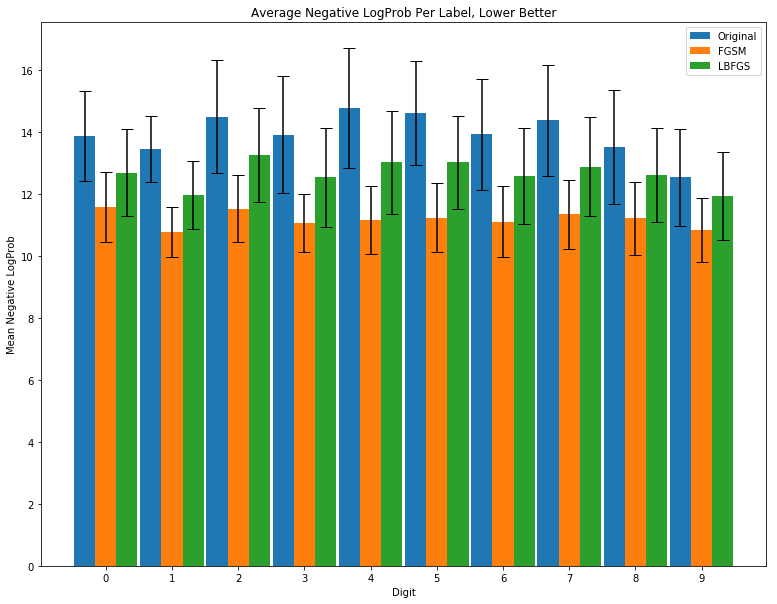

In [404]:
orig_prob_scores = np.array(orig_prob_scores)
adv_prob_scores = np.array(adv_prob_scores)
l_orig_labels = np.array(l_orig_labels)
orig_labels = np.array(orig_labels)
l_adv_prob_scores = np.array(l_adv_prob_scores)
mean_orig_prob_list = []
mean_orig_std = []
mean_adv_prob_list = []
mean_adv_std = []
l_prob_list = []
l_std = []
for i in range(10):
    var = -1.0 * orig_prob_scores[orig_labels == i]
    var_adv = -1.0 * adv_prob_scores[orig_labels == i]
    l_var = -1.0 * l_adv_prob_scores[l_orig_labels == i]
    mean_orig_prob_list.append(np.mean(var))
    mean_orig_std.append(np.std(var))
    mean_adv_prob_list.append(np.mean(var_adv))
    mean_adv_std.append(np.std(var_adv))
    l_prob_list.append(np.mean(l_var))
    l_std.append(np.std(l_var))

plt.figure(figsize=(13,10))
ax = plt.subplot(1,1,1);
plt.bar(1.25*np.arange(10) - 0.4, mean_orig_prob_list, yerr=mean_orig_std, width=0.4, align='center', label='Original', capsize=6);
#plt.subplot(2,1,2)
plt.bar(1.25*np.arange(10), mean_adv_prob_list, yerr=mean_adv_std, width=0.4, align='center', label='FGSM', capsize=6);
plt.bar(1.25*np.arange(10) + 0.4, l_prob_list, yerr=l_std, width=0.4, align='center', label='LBFGS', capsize=6);
plt.xticks(1.25*np.arange(10), labels=np.arange(10))
plt.legend()
plt.ylabel('Mean Negative LogProb')
plt.xlabel('Digit')
plt.title('Average Negative LogProb Per Label, Lower Better');

### KLD and the Labels

In [408]:
np.array([x.data.cpu().detach().item() for x in orig_klds])

array([18.55380058, 21.36381149, 18.78365326, ..., 17.29174232,
       19.68292999, 21.13351059])

In [ ]:
orig_klds = np.array([x.data.cpu().detach().item() for x in orig_klds])
adv_klds = np.array([x.data.cpu().detach().item() for x in adv_klds])
l_adv_klds = np.array([x.data.cpu().detach().item() for x in l_adv_klds])

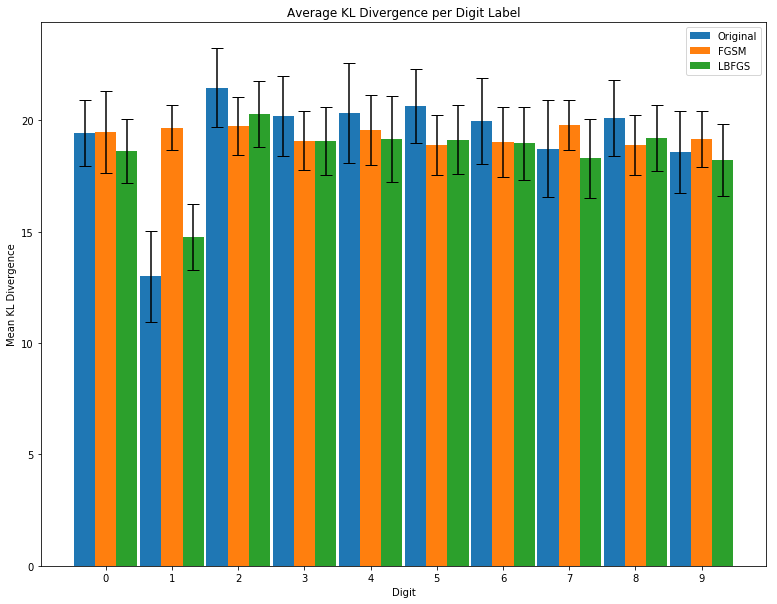

In [411]:
l_orig_labels = np.array(l_orig_labels)
orig_labels = np.array(orig_labels)
mean_orig_prob_list = []
mean_orig_std = []
mean_adv_prob_list = []
mean_adv_std = []
l_prob_list = []
l_std = []
for i in range(10):
    var = orig_klds[orig_labels == i]
    var_adv = adv_klds[orig_labels == i]
    l_var = l_adv_klds[l_orig_labels == i]
    mean_orig_prob_list.append(np.mean(var))
    mean_orig_std.append(np.std(var))
    mean_adv_prob_list.append(np.mean(var_adv))
    mean_adv_std.append(np.std(var_adv))
    l_prob_list.append(np.mean(l_var))
    l_std.append(np.std(l_var))

plt.figure(figsize=(13,10))
ax = plt.subplot(1,1,1);
plt.bar(1.25*np.arange(10) - 0.4, mean_orig_prob_list, yerr=mean_orig_std, width=0.4, align='center', label='Original', capsize=6);
#plt.subplot(2,1,2)
plt.bar(1.25*np.arange(10), mean_adv_prob_list, yerr=mean_adv_std, width=0.4, align='center', label='FGSM', capsize=6);
plt.bar(1.25*np.arange(10) + 0.4, l_prob_list, yerr=l_std, width=0.4, align='center', label='LBFGS', capsize=6);
plt.xticks(1.25*np.arange(10), labels=np.arange(10))
plt.legend()
plt.ylabel('Mean KL Divergence')
plt.xlabel('Digit')
plt.title('Average KL Divergence per Digit Label');

In [308]:
idx = adv_prob_scores < orig_prob_scores

In [309]:
orig_labels, adv_labels = np.array(orig_labels), np.array(adv_labels)

In [310]:
filt_orig_labels = orig_labels[idx]

In [311]:
np.bincount(filt_orig_labels)

array([ 8,  1,  0,  6,  0,  0,  2,  0,  6, 15])

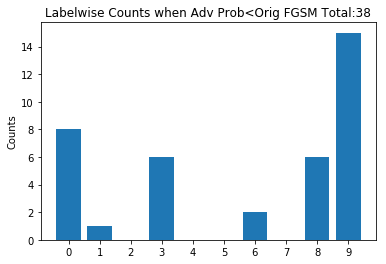

In [347]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(filt_orig_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('Labelwise Counts when Adv Prob<Orig FGSM Total:'+str(np.sum(np.bincount(filt_orig_labels))));

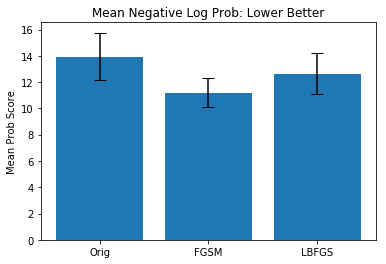

In [348]:
mean_scores = [-1*np.mean(orig_prob_scores), -1*np.mean(adv_prob_scores), -1*np.mean(l_adv_prob_scores)]
errs = [np.std(orig_prob_scores), np.std(adv_prob_scores), np.std(l_adv_prob_scores)]
plt.bar(range(len(mean_scores)), mean_scores, yerr=errs, capsize=6)
plt.xticks([0,1,2], ['Orig', 'FGSM', 'LBFGS'])
plt.ylabel('Mean Prob Score')
plt.title('Mean Negative Log Prob: Lower Better');
#plt.ylim((13,14.1))

(0, 0.10227648807503863)

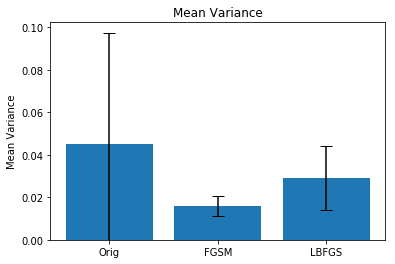

In [350]:
mean_scores = [np.mean(orig_vars), np.mean(adv_vars), np.mean(l_adv_vars)]
err_scores = [np.std(orig_vars), np.std(adv_vars), np.std(l_adv_vars)]
plt.bar(range(len(mean_scores)), mean_scores, yerr=err_scores, capsize=6)
plt.xticks([0,1,2], ['Orig', 'FGSM', 'LBFGS'])
plt.ylabel('Mean Variance')
plt.title('Mean Variance');
plt.ylim(bottom=0)

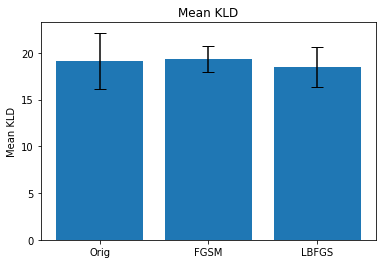

In [413]:
mean_scores = [np.mean(orig_klds), np.mean(adv_klds), np.mean(l_adv_klds)]
err_scores = [np.std(orig_klds), np.std(adv_klds), np.std(l_adv_klds)]
plt.bar(range(len(mean_scores)), mean_scores, yerr=err_scores, capsize=6)
plt.xticks([0,1,2], ['Orig', 'FGSM', 'LBFGS'])
plt.ylabel('Mean KLD')
plt.title('Mean KLD');
plt.ylim(bottom=0);

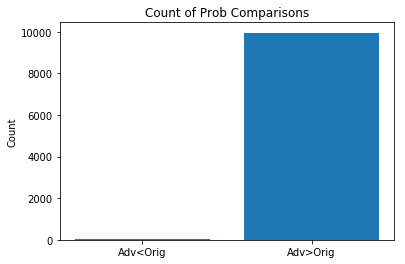

In [318]:
mean_scores = [count, len(orig_prob_scores) - count]
plt.bar(range(len(mean_scores)), mean_scores)
plt.xticks([0,1], ['Adv<Orig', 'Adv>Orig'])
plt.ylabel('Count')
plt.title('Count of Prob Comparisons');
#plt.ylim((13,14))

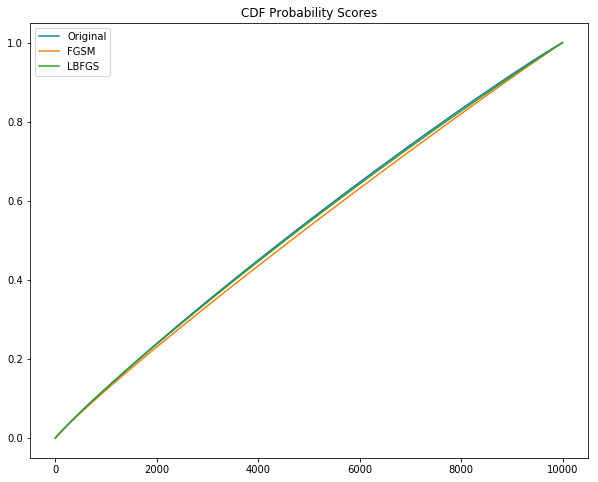

In [430]:
plt.figure(figsize=(10,8));
plt.plot(np.cumsum(np.sort(orig_prob_scores))/np.sum(orig_prob_scores), label='Original');
plt.plot(np.cumsum(np.sort(adv_prob_scores))/np.sum(adv_prob_scores), label='FGSM');
plt.plot(np.cumsum(np.sort(l_adv_prob_scores))/np.sum(l_adv_prob_scores), label='LBFGS');
plt.legend();
plt.title('CDF Probability Scores');

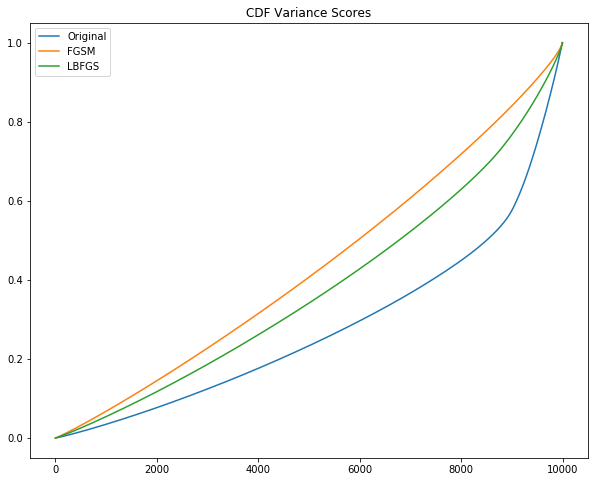

In [426]:
plt.figure(figsize=(10,8));
plt.plot(np.cumsum(np.sort(orig_vars))/np.sum(orig_vars), label='Original');
plt.plot(np.cumsum(np.sort(adv_vars))/np.sum(adv_vars), label='FGSM');
plt.plot(np.cumsum(np.sort(l_adv_vars))/np.sum(l_adv_vars), label='LBFGS');
plt.legend();
plt.title('CDF Variance Scores');

In [673]:
np.bincount(adv_labels)

array([ 261,  166, 1051, 2706,  622,  526,  225,  719, 2544, 1170])

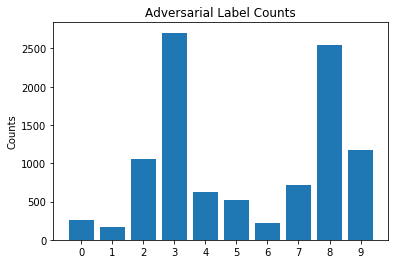

In [674]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(adv_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('Adversarial Label Counts');

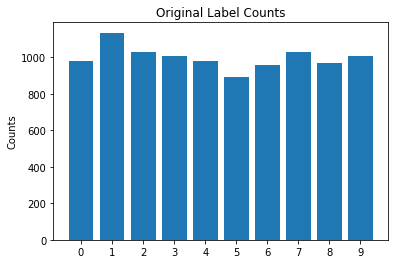

In [675]:
#plt.hist(filt_orig_labels, range(10))
plt.bar(np.arange(10), np.bincount(orig_labels))
plt.xticks(range(10));
plt.ylabel('Counts');
plt.title('Original Label Counts');

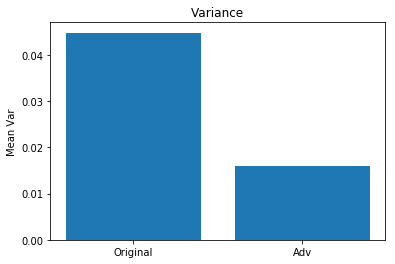

In [322]:
mean_scores = [np.mean(orig_vars), np.mean(adv_vars)]
plt.bar(range(len(mean_scores)), mean_scores)
plt.xticks([0,1], ['Original', 'Adv'])
plt.ylabel('Mean Var')
plt.title('Variance');

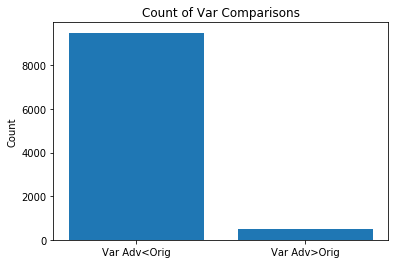

In [323]:
mean_scores = [count_var, len(orig_prob_scores) - count_var]
plt.bar(range(len(mean_scores)), mean_scores)
plt.xticks([0,1], ['Var Adv<Orig', 'Var Adv>Orig'])
plt.ylabel('Count')
plt.title('Count of Var Comparisons');
#plt.ylim((13,14))

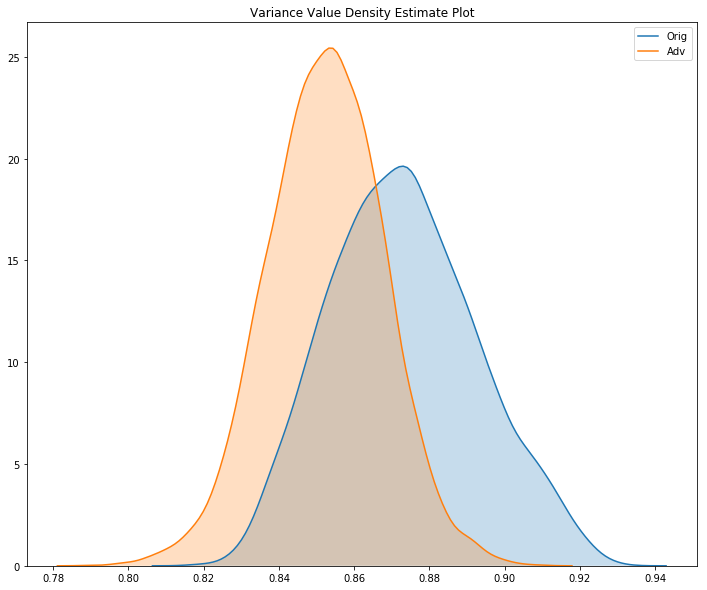

In [1152]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(orig_vars, shade=True, label='Orig');
sns.kdeplot(adv_vars, shade=True, label='Adv');
plt.title('Variance Value Density Estimate Plot');

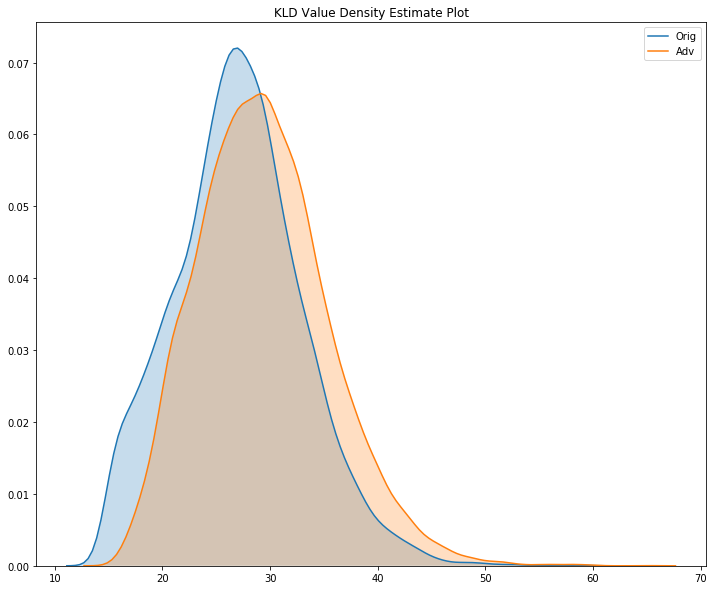

In [1149]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(orig_klds, shade=True, label='Orig');
sns.kdeplot(adv_klds, shade=True, label='Adv');
plt.title('KLD Value Density Estimate Plot');

In [1140]:
import seaborn as sns

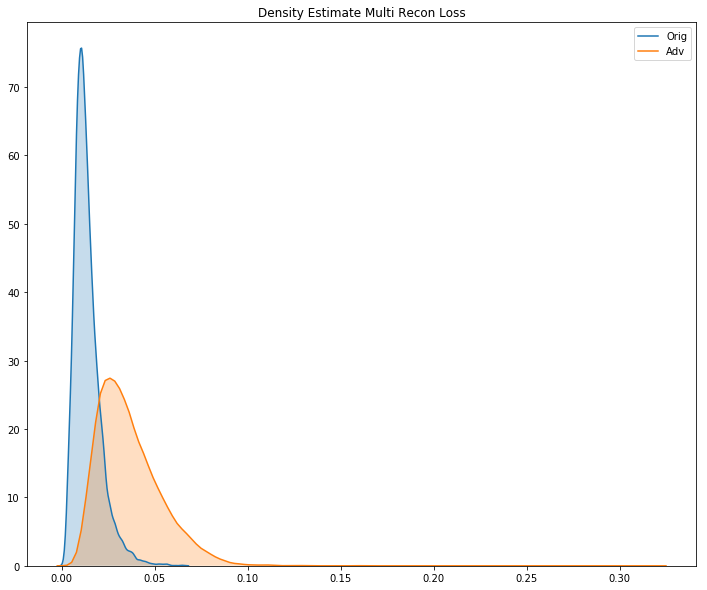

In [1151]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(multi_orig_recon_loss, shade=True, label='Orig');
sns.kdeplot(multi_adv_recon_loss, shade=True, label='Adv');
plt.title('Density Estimate Multi Recon Loss');

## Trying Fashion MNIST data as anomaly

In [1102]:
transform = transforms.Compose([transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [1103]:
f_itr = iter(testloader)

In [1104]:

f1, flab1 = f_itr.next()

In [1105]:
f1_np = f1.permute(0,2,3,1).data.squeeze().numpy()

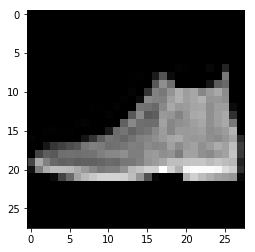

In [1106]:
plt.imshow(f1_np, cmap='gray')

In [1107]:
mu_1, logvar_1 = vae.encode(f1)

In [1108]:
z_1 = vae.reparameterize(mu_1, logvar_1)
rec_test2 = vae.decode(z_1)

In [1109]:
rec_2 = rec_test2.view((1,28,28))

In [1110]:
rec_2_np = rec_2.data.cpu().squeeze().numpy()

In [1111]:
fmodel = foolbox.models.PyTorchModel(model, bounds=(-1, 1), num_classes=10, preprocessing=(mean, std))

In [1112]:
bleh_2 = np.expand_dims(rec_2_np, 0)
np.argmax(fmodel.predictions(bleh_2))

2

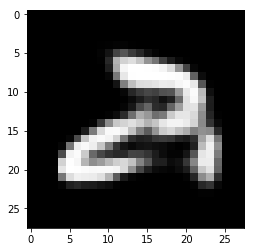

In [1113]:
plt.imshow(rec_2_np, cmap='gray')

In [1121]:
compute_kld(mu_1, logvar_1)

tensor(42.5537, grad_fn=<MulBackward0>)

In [1114]:
m_preds = []
m_scores = []
for _ in range(MULTI_K):
    zz = vae.reparameterize(mu_1, logvar_1)
    rrec = vae.decode(zz).view((1,28,28))
    rrec_num = rrec.data.cpu().numpy()
    pred = fmodel.predictions(rrec_num)
    m_preds.append(np.argmax(pred))
    m_scores.append(softmax(pred))

In [1115]:
m_scores

[array([6.5456902e-08, 1.4508225e-09, 9.9997854e-01, 6.4312576e-07,
        2.5359693e-12, 8.1302503e-09, 1.1432580e-12, 5.7611524e-06,
        1.5020103e-05, 2.6526872e-10], dtype=float32),
 array([1.4988758e-06, 8.5284568e-10, 9.9611378e-01, 9.1104092e-05,
        1.2972577e-10, 8.5364725e-08, 2.1432339e-11, 5.7833400e-05,
        3.7354582e-03, 1.2263459e-07], dtype=float32),
 array([3.9979132e-06, 3.7227988e-08, 9.9583167e-01, 1.3134626e-04,
        1.0131870e-09, 1.4021934e-07, 4.8650230e-11, 1.3397937e-04,
        3.8982544e-03, 5.5367354e-07], dtype=float32),
 array([2.1489751e-07, 4.0157331e-09, 9.9994886e-01, 1.7286507e-06,
        3.1768848e-11, 4.7316715e-09, 2.4262304e-12, 8.3165760e-06,
        4.0817660e-05, 6.1487015e-10], dtype=float32),
 array([5.4830965e-05, 6.2566720e-08, 9.9969268e-01, 3.1538027e-06,
        5.4922672e-10, 4.1738049e-06, 6.6524797e-10, 9.5355836e-06,
        2.3560015e-04, 9.6184447e-09], dtype=float32),
 array([1.9043632e-06, 9.6817425e-09, 9.99637

In [1116]:
find_prob(mu_1)

(array([0.39879952, 0.39605323, 0.39495898, 0.39823409, 0.39685905,
        0.39496702, 0.39195516, 0.39812592, 0.21332871, 0.39827974,
        0.3669746 , 0.39761196, 0.21133313, 0.06229177, 0.39464828,
        0.3980164 , 0.3989327 , 0.39850361, 0.39890764, 0.3683086 ,
        0.38457828, 0.39842934, 0.39712685, 0.39824674, 0.39885001,
        0.39888814, 0.39843874, 0.39573184, 0.38849008, 0.39890477,
        0.39176175, 0.03792173, 0.040298  , 0.17934139, 0.39866148,
        0.39616441, 0.39827776, 0.38600023, 0.39886458, 0.39842346,
        0.39089028, 0.22169982, 0.39892052, 0.38924169, 0.22808588,
        0.39136643, 0.03555266, 0.39881558, 0.39893999, 0.39647479,
        0.39085705, 0.39279082, 0.39144277, 0.3988751 , 0.38781199,
        0.38934035, 0.39695007, 0.04900093, 0.39791077, 0.39800516,
        0.29887674, 0.07808783, 0.3951861 , 0.3979994 , 0.39846898,
        0.39772196, 0.39756484, 0.39739972, 0.39026854, 0.39812559,
        0.39810349, 0.39201291, 0.39744339, 0.27

In [1154]:
itr =iter(c_test_loader)
#fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
count = 0
fash_prob_scores = []

fash_vars = []

fash_klds = []

multi_fash_recon_loss = []

multi_fash_recon_preds = []

MULTI_K = 10

pbar = tqdm(total=len(testloader))

vae = vae.cpu()

cnt = 0

for i, (img, lbl) in enumerate(testloader):
    
    #print(img.shape)
    #img, lbl = img.numpy(), lbl.numpy()
    img_denorm = img
    mu, logvar = vae.encode(img_denorm)
    _, prob = find_prob(mu)
    # Attack
    
        # Get recon pred
        #z = vae.sampling(mu, logvar)
#     z = mu
#     rec = vae.decode(z)
#     rec = rec.view((1,28,28))
#     rec = rec.data.cpu().numpy()
#     orig_recon_labels.append(np.argmax(fmodel.predictions(rec)))
    kld = compute_kld(mu, logvar)
    fash_klds.append(kld)
    # Multi gen stuff
    #mult_scores = []
    mult_preds = []
    rec_loss = []
    for _ in range(MULTI_K):
        zz = vae.reparameterize(mu, logvar)
        rrec = vae.decode(zz).view((1,28,28))
        rrec_num = rrec.data.cpu().numpy()
        pred = fmodel.predictions(rrec_num)
        mult_preds.append(np.argmax(pred))
        #mult_scores.append(softmax(pred))
        rec_loss.append(F.mse_loss(rrec.view(-1,784).cpu(), img_denorm.view(-1, 784).cpu()).item())

    multi_fash_recon_preds.append(mult_preds)
    #multi_fash_recon_scores.append(mult_scores)
    multi_fash_recon_loss.append(np.mean(rec_loss))
    # Generate Adversary
    # Collect the prob scores
    fash_prob_scores.append(prob)
    fash_vars.append(logvar.exp().mean().item())
    pbar.update(1)
    #if cnt >= 5:
    #    break
pbar.close()

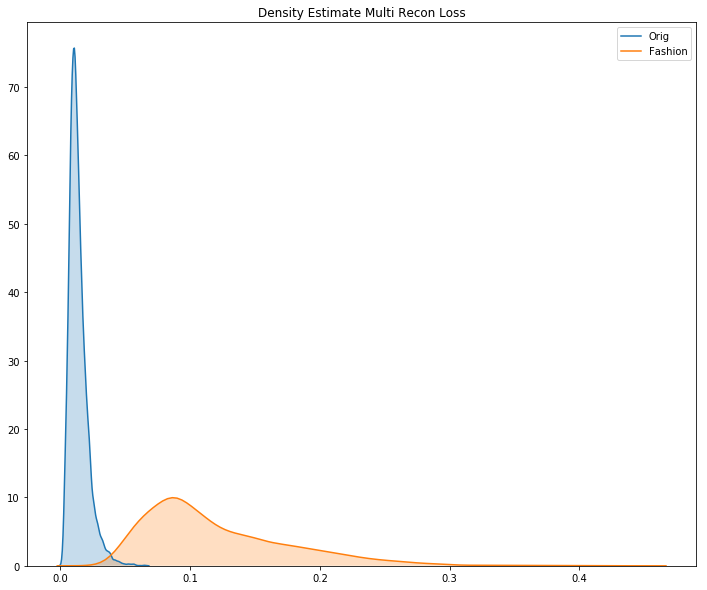

In [1160]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(multi_orig_recon_loss, shade=True, label='Orig');
sns.kdeplot(multi_fash_recon_loss, shade=True, label='Fashion');
plt.title('Density Estimate Multi Recon Loss');

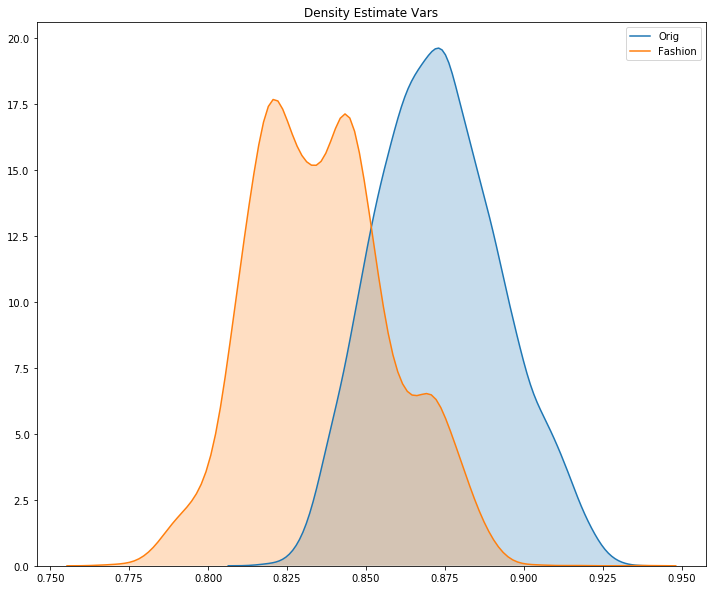

In [1161]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(orig_vars, shade=True, label='Orig');
sns.kdeplot(fash_vars, shade=True, label='Fashion');
plt.title('Density Estimate Vars');

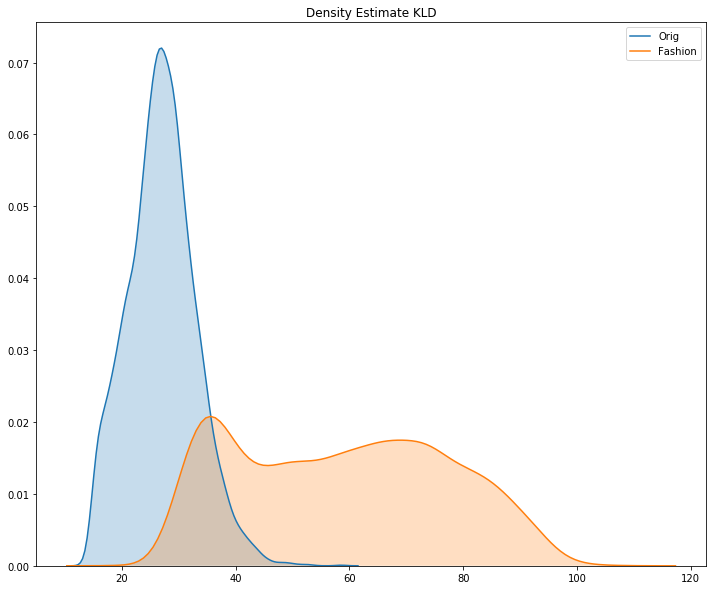

In [1162]:
plt.figure(figsize=(12,10));
#plt.hist([multi_orig_recon_loss, multi_adv_recon_loss], bins=50);
sns.kdeplot(orig_klds, shade=True, label='Orig');
sns.kdeplot(fash_klds, shade=True, label='Fashion');
plt.title('Density Estimate KLD');

# Experiment with z_dim 2

In [1348]:
choice_attack = 'fgsm'

In [1366]:
itr =iter(c_test_loader)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))
count = 0
orig_prob_scores = []
adv_prob_scores = []
orig_labels = []
adv_labels = []
orig_vars = []
adv_vars = []
orig_recon_labels = []
adv_recon_labels = []
orig_klds = []
adv_klds = []

cosine_mu = []

orig_mu = []
adv_mu = []

orig_var = []
adv_var = []

count_var = 0
count_kld = 0

multi_orig_recon_preds, multi_orig_recon_scores = [], []
multi_adv_recon_preds, multi_adv_recon_scores = [], []

multi_orig_recon_loss = []
multi_adv_recon_loss = []

MULTI_K = 1

pbar = tqdm(total=len(c_test_loader) * args.test_batch_size)

vae = vae.cpu()

cnt = 0

for i, (imgs, lbls) in enumerate(c_test_loader):
    #print(i)
    #imgs, lbls = itr.next()
    cnt += 1
    for j in range(len(imgs)):
        #print(i,j)
        img, lbl = imgs[j], lbls[j]
        #print(img.shape)
        #img, lbl = img.numpy(), lbl.numpy()
        img_denorm = img * std + mean
        mu, logvar = vae.encode(img_denorm.unsqueeze(0))
        _, prob = find_prob(mu)
        # Attack
        #print(img.shape, img)
        adversarial = attack(input_or_adv=img_denorm.numpy(), label=lbl.numpy())
        #print('adversarial class', np.argmax(fmodel.predictions(adversarial)))
        if adversarial is not None:
            # Get recon pred
            #z = vae.sampling(mu, logvar)
            orig_mu.append(mu.data.cpu().numpy()[0])
            orig_var.append(logvar.exp().data.cpu().numpy()[0])
            z = mu
            rec = vae.decode(z)
            rec = rec.view((1,28,28))
            rec = rec.data.cpu().numpy()
            orig_recon_labels.append(np.argmax(fmodel.predictions(rec)))
            kld = compute_kld(mu, logvar)
            orig_klds.append(kld)
            # Multi gen stuff
            mult_scores = []
            mult_preds = []
            rec_loss = []
            for _ in range(MULTI_K):
                zz = vae.reparameterize(mu, logvar)
                rrec = vae.decode(zz).view((1,28,28))
                rrec_num = rrec.data.cpu().numpy()
                pred = fmodel.predictions(rrec_num)
                mult_preds.append(np.argmax(pred))
                mult_scores.append(softmax(pred))
                rec_loss.append(F.mse_loss(rrec.view(-1,784).cpu(), img_denorm.view(-1, 784).cpu()).item())
                
            multi_orig_recon_preds.append(mult_preds)
            multi_orig_recon_scores.append(mult_scores)
            multi_orig_recon_loss.append(np.mean(rec_loss))
            # Generate Adversary
            adv = torch.Tensor(adversarial).unsqueeze(0)
            #print(adv)
            #adv_denorm = adv*std + mean
            adv_denorm = adv
            mu_a, logvar_a = vae.encode(adv_denorm)
            
            # Same Mult
            
            mult_adv_scores = []
            mult_adv_preds = []
            adv_rec_loss = []
            for _ in range(MULTI_K):
                zz_a = vae.reparameterize(mu_a, logvar_a)
                rrec_a = vae.decode(zz_a).view((1,28,28))
                rrec_a_num = rrec_a.data.cpu().numpy()
                pred_a = fmodel.predictions(rrec_a_num)
                mult_adv_preds.append(np.argmax(pred_a))
                mult_adv_scores.append(softmax(pred_a))
                adv_rec_loss.append(F.mse_loss(rrec_a.view(-1,784).cpu(), adv_denorm.view(-1, 784).cpu()).item())
                
            multi_adv_recon_preds.append(mult_adv_preds)
            multi_adv_recon_scores.append(mult_adv_scores)
            multi_adv_recon_loss.append(np.mean(adv_rec_loss))
            
            kld_a = compute_kld(mu_a, logvar_a)
            adv_klds.append(kld_a)
            # Get adv rec pred
            #z_a = vae.sampling(mu, logvar)
            z_a = mu_a
            adv_mu.append(mu_a.data.cpu().numpy()[0])
            adv_var.append(logvar_a.exp().data.cpu().numpy()[0])
            rec_a = vae.decode(z_a)
            rec_a = rec_a.view((1,28,28))
            rec_a = rec_a.data.cpu().numpy()
            adv_recon_labels.append(np.argmax(fmodel.predictions(rec_a)))
            #print(mu, mu_a)
            _, prob_a = find_prob(mu_a)
            # Collect the prob scores
            orig_prob_scores.append(prob)
            adv_prob_scores.append(prob_a)
            orig_labels.append(lbl)
            orig_vars.append(logvar.exp().mean().item())
            adv_vars.append(logvar_a.exp().mean().item())
            adv_labels.append(np.argmax(fmodel.predictions(adversarial)))
            cosine_mu.append(cosine(mu.data.cpu().numpy(), mu_a.data.cpu().numpy()))
            if prob_a < prob:
                count += 1
            if adv_vars[-1] < orig_vars[-1]:
                count_var += 1
            if adv_klds[-1] < orig_klds[-1]:
                count_kld += 1
                #print(count, ":", "Actual:", prob, "Adv:", prob_a, "Label:", lbl.item(), "Adversary Label:", np.argmax(fmodel.predictions(adversarial)))
        pbar.update(1)
        #if cnt >= 5:
        #    break
pbar.close()

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack becaus

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack becaus

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack becaus

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack becaus

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


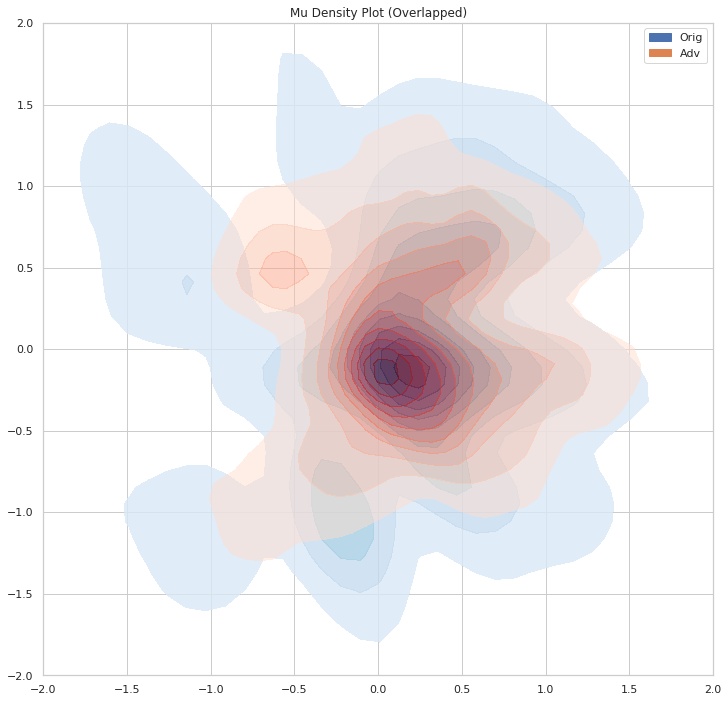

In [1398]:
plt.figure(figsize=(12,12));
sns.kdeplot(orig_mu, shade=True, cmap='Blues', label='Orig', shade_lowest=False, alpha=0.8);
sns.kdeplot(adv_mu, shade=True, label='Adv', cmap='Reds', shade_lowest=False, alpha=0.5);
plt.xlim(-2,2);
plt.ylim(-2,2);
plt.title('Mu Density Plot (Overlapped)')
plt.legend();

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


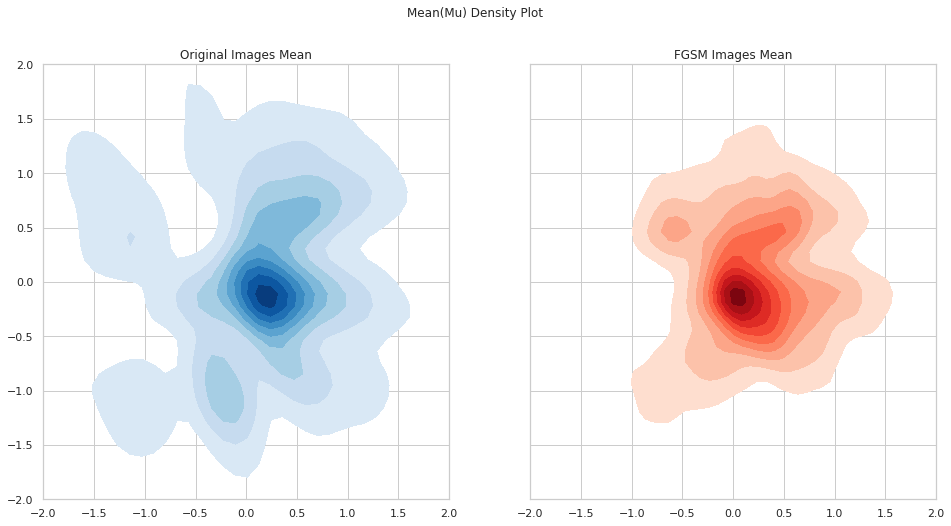

In [1383]:
# plt.figure(figsize=(16,8))
# ax1=plt.subplot(1,2,1);
# sns.kdeplot(orig_mu, shade=True, cmap='Blues', label='Orig', shade_lowest=False, ax=ax1);
# ax2=plt.subplot(1,2,2);
# sns.kdeplot(adv_mu, shade=True, label='Adv', cmap='Reds', shade_lowest=False, sharex=ax1, sharey=ax1, ax=ax2);

# plt.figure(figsize=(16,8))
# ax1=plt.subplot(1,2,1);
# sns.kdeplot(orig_mu, shade=True, cmap='Blues', label='Orig', shade_lowest=False, ax=ax1);
# ax2=plt.subplot(1,2,2);
# sns.kdeplot(adv_mu, shade=True, label='Adv', cmap='Reds', shade_lowest=False, sharex=ax1, sharey=ax1, ax=ax2);

f, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True);
axes[0].set_xlim((-2,2));
axes[0].set_ylim((-2,2));
sns.kdeplot(orig_mu, shade=True, cmap='Blues', label='Orig', shade_lowest=False, ax=axes[0]);
axes[0].set_title('Original Images Mean');
sns.kdeplot(adv_mu, shade=True, label='Adv', cmap='Reds', shade_lowest=False, ax=axes[1]);
axes[1].set_title('FGSM Images Mean');
f.suptitle('Mean(Mu) Density Plot');

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


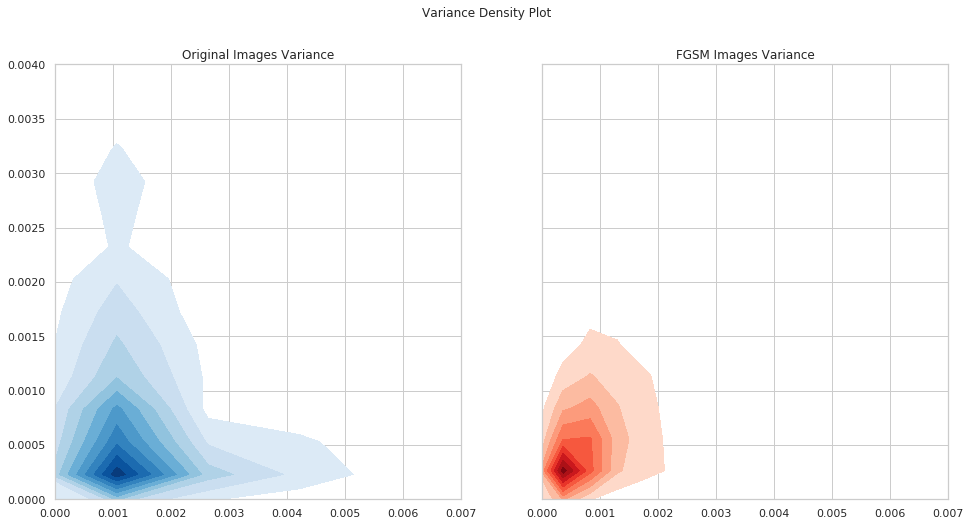

In [1381]:
# plt.figure(figsize=(16,8))
# ax1=plt.subplot(1,2,1);
# sns.kdeplot(orig_mu, shade=True, cmap='Blues', label='Orig', shade_lowest=False, ax=ax1);
# ax2=plt.subplot(1,2,2);
# sns.kdeplot(adv_mu, shade=True, label='Adv', cmap='Reds', shade_lowest=False, sharex=ax1, sharey=ax1, ax=ax2);

f, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True);
axes[0].set_xlim((0, 0.007));
axes[0].set_ylim((0, 0.004));
sns.kdeplot(orig_var, shade=True, cmap='Blues', label='Orig', shade_lowest=False, ax=axes[0]);
axes[0].set_title('Original Images Variance');
sns.kdeplot(adv_var, shade=True, label='Adv', cmap='Reds', shade_lowest=False, ax=axes[1]);
axes[1].set_title('FGSM Images Variance');
f.suptitle('Variance Density Plot');

/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/ayanm/anaconda3/envs/tbv/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


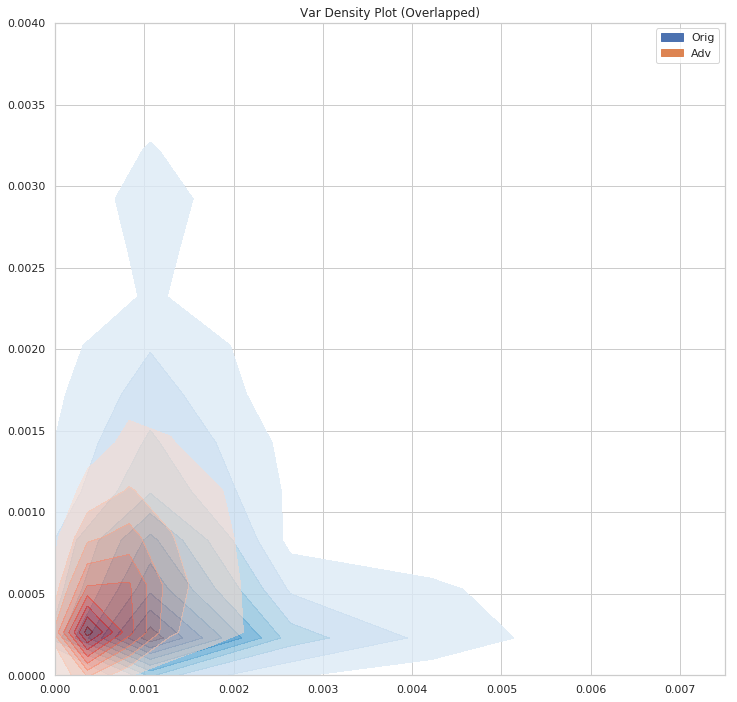

In [1399]:
# sns.kdeplot(orig_var, shade=True, shade_lowest=False)
# plt.xlim(0, 0.0075);
# plt.ylim(0, 0.004);
# sns.kdeplot(adv_var, shade=True, shade_lowest=False)

plt.figure(figsize=(12,12));
sns.kdeplot(orig_var, shade=True, cmap='Blues', label='Orig', shade_lowest=False, alpha=0.8);
sns.kdeplot(adv_var, shade=True, label='Adv', cmap='Reds', shade_lowest=False, alpha=0.5);
plt.xlim(0, 0.0075);
plt.ylim(0, 0.004);
plt.title('Var Density Plot (Overlapped)');
plt.legend();